# Leios simulation analysis at tag `leios-2025w23`

## Load packages

In [1]:
suppressMessages({
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
})

## TPS experiment

In [2]:
label <- "Rust simulator, pseudo-mainnet, 10 slot/stage, 328 kB/IB maximum, 1.5 EB/stage, multiple shards"

### Analysis of lifecycles and efficiencies

#### Read the lifecycle results

In [3]:
lifecycle <- fread("results/tps3x/lifecycle.csv.gz", stringsAsFactors=TRUE)
lifecycle[, `Kind`:=factor(`Kind`, levels=c("RB", "EB", "IB", "TX"))]
lifecycle[, `tps`:=factor(paste(`tps`, "tx/s"), levels=paste(c(1,3,10,30,100,300,1000), "tx/s"))]
lifecycle %>% summary

 simulator            tps        Kind             Item           Size [B]     
 rust:155470   1 tx/s   :  862   RB:   173   0      :     6   Min.   :     8  
               3 tx/s   : 2263   EB:   439   1      :     6   1st Qu.:   429  
               10 tx/s  : 7208   IB: 14525   10     :     6   Median :   991  
               30 tx/s  :21693   TX:140333   100    :     6   Mean   :  3118  
               100 tx/s :28931               101    :     6   3rd Qu.:  2317  
               300 tx/s :94513               102    :     6   Max.   :188424  
               1000 tx/s:    0               (Other):155434                   
   References      Created [s]       To IB [s]        To EB [s]     
 Min.   : 0.000   Min.   :  0.13   Min.   : 61.13   Min.   : 30.08  
 1st Qu.: 1.000   1st Qu.:122.27   1st Qu.:148.13   1st Qu.:170.07  
 Median : 1.000   Median :189.67   Median :210.13   Median :220.07  
 Mean   : 1.365   Mean   :210.94   Mean   :234.79   Mean   :250.42  
 3rd Qu.: 1.000   3rd Q

#### Range of transaction injection

In [4]:
txFirst <- 60
txLast <- 660
txWindow <- txLast - txFirst

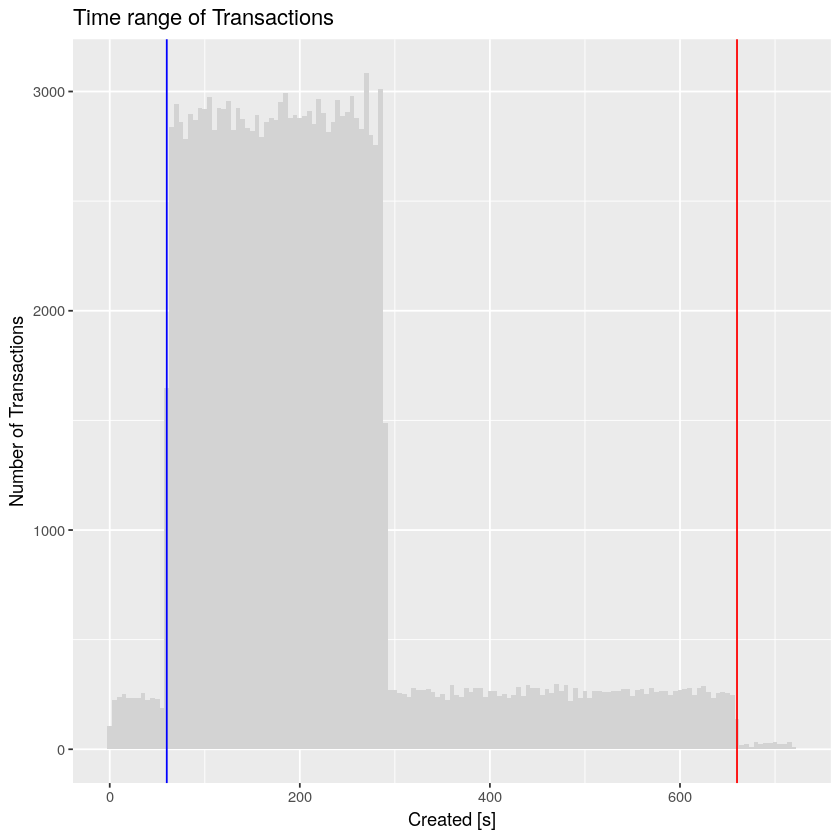

In [5]:
ggplot(lifecycle, aes(x=`Created [s]`)) +
    geom_histogram(binwidth=5, fill="lightgray") +
    geom_vline(xintercept=txFirst, color="blue") +
    geom_vline(xintercept=txLast, color="red") +
    ylab("Number of Transactions") +
    ggtitle("Time range of Transactions")

#### Actual TPS

In [6]:
lifecycle[`Kind` == "TX" & `Created [s]` >= txFirst & `Created [s]` <= txLast, .(`Actual TPS`=.N / txWindow), .(`Design TPS`=`tps`)]

Design TPS,Actual TPS
<fct>,<dbl>
1 tx/s,1.098333
10 tx/s,10.665000
3 tx/s,3.205000
100 tx/s,43.351667
30 tx/s,32.343333
300 tx/s,143.225000


#### Check that the IB rate is sufficient for

In [7]:
lifecycle[`Kind` == "TX", .(`Size [IB/s]`=sum(`Size [B]`)/196608/3600), .(`tps`)][
    data.table(`tps`=c("1 tx/s", "3 tx/s", "10 tx/s", "30 tx/s", "100 tx/s", "300 tx/s"), `IB rate [IB/s]`=3*c(0.015, 0.045, 0.15, 0.45, 1.5, 4.5)),
    on="tps"
][, .(
      `tps`,
      `Size [IB/s]`,
      `IB rate [IB/s]`,
      `Okay?`=`Size [IB/s]`<=`IB rate [IB/s]`
)]

tps,Size [IB/s],IB rate [IB/s],Okay?
<chr>,<dbl>,<dbl>,<lgl>
1 tx/s,0.001578679,0.045,TRUE
3 tx/s,0.004680648,0.135,TRUE
10 tx/s,0.015292059,0.450,TRUE
30 tx/s,0.046772686,1.350,TRUE
100 tx/s,0.062634009,4.500,TRUE
300 tx/s,0.207710075,13.500,TRUE


#### Size of persisted data

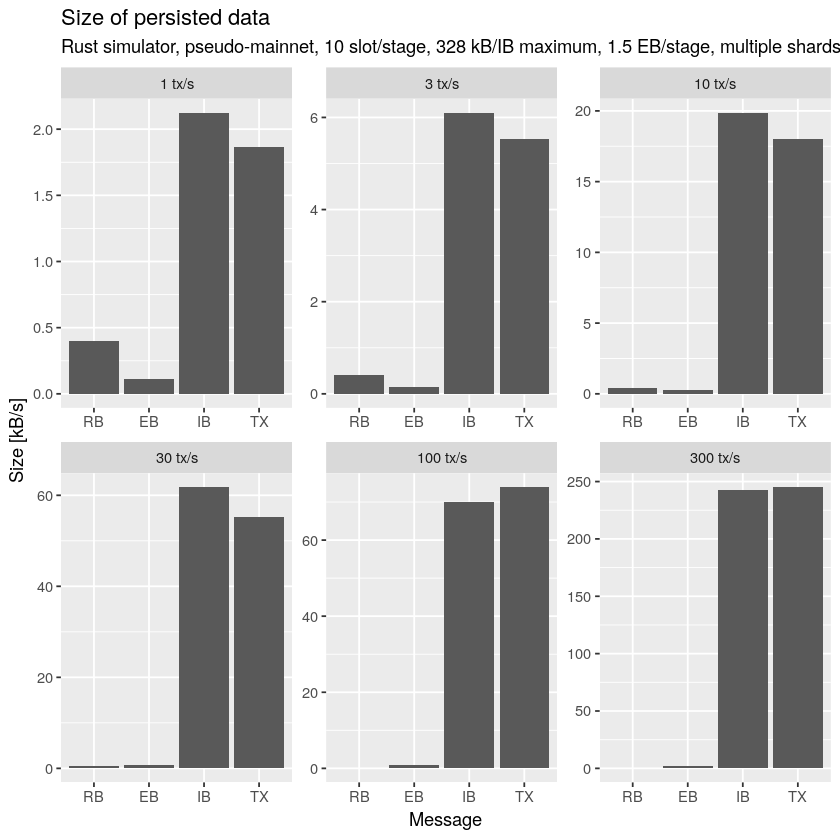

In [8]:
ggplot(
    lifecycle[, .(`Size [kB/s]`=sum(`Size [B]`)/1e3/600), .(`Message`=`Kind`, `tps`)],
    aes(x=`Message`, y=`Size [kB/s]`)
) + geom_bar(stat="identity") +
    facet_wrap(`tps` ~ ., scales="free") +
    ggtitle("Size of persisted data", subtitle=label)

In [9]:
ggsave("plots/tps3x/sizes.png", units="in", dpi=150, width=8, height=6)

In [10]:
ggsave("plots/tps3x/sizes.svg", units="in", dpi=150, width=8, height=6)

#### Spatial efficiency

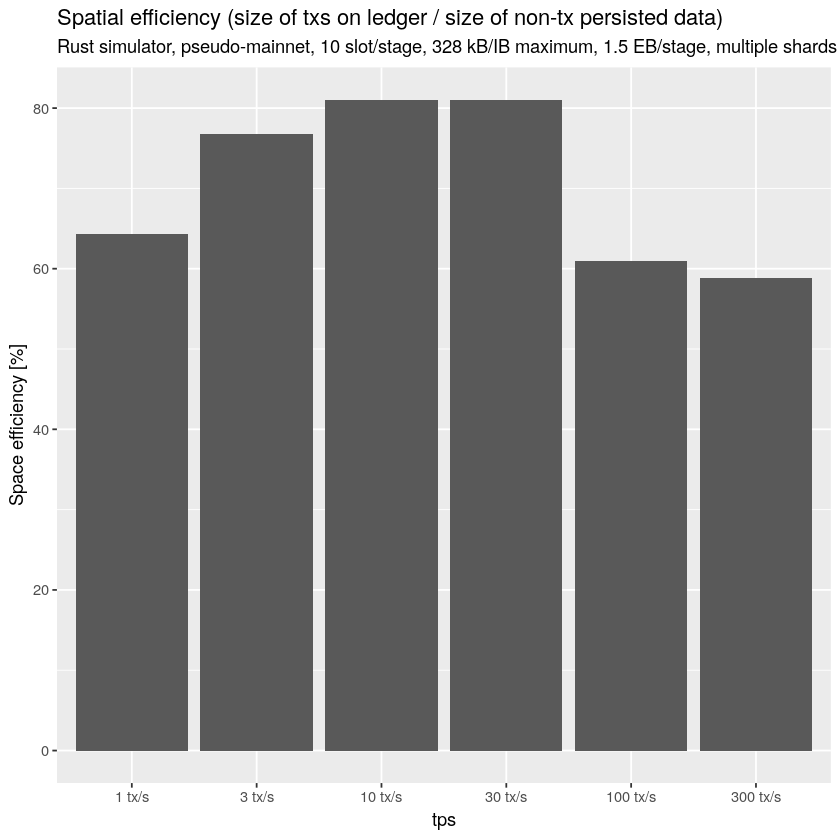

In [11]:
ggplot(
    lifecycle[
        `Kind` == "TX", 
        .(`Tx size [B]`=sum(ifelse(is.na(`To RB [s]`) & is.na(`In RB [s]`), 0, 1.0 * `Size [B]`))),
        .(`tps`)
    ][
        lifecycle[
            `Kind` != "TX", 
            .(`Non-tx size [B]`=sum(as.numeric(`Size [B]`))), 
            .(`tps`)
        ],
        on=c("tps")
    ][, .(`tps`, `Space efficiency [%]`=100*`Tx size [B]`/`Non-tx size [B]`)],
    aes(x=`tps`, y=`Space efficiency [%]`)
) +
    geom_bar(stat="identity") +
    ggtitle("Spatial efficiency (size of txs on ledger / size of non-tx persisted data)", label)

In [12]:
ggsave("plots/tps3x/spatial-efficiency.png", units="in", dpi=150, width=8, height=6)

In [13]:
ggsave("plots/tps3x/spatial-efficiency.svg", units="in", dpi=150, width=8, height=6)

#### Time to reach the ledger

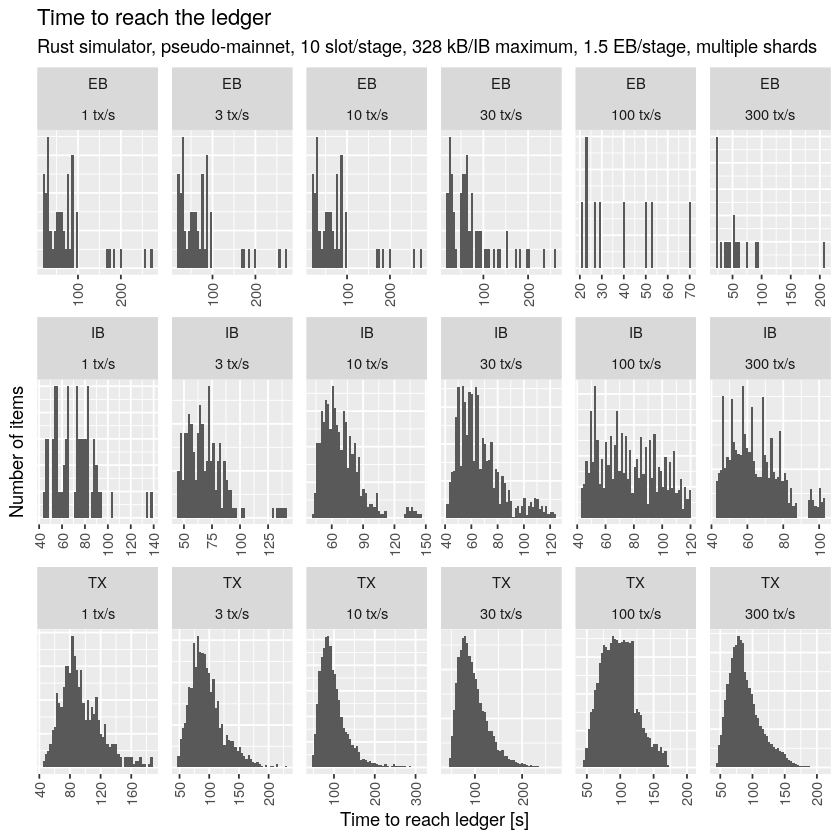

In [14]:
ggplot(
    lifecycle[
        `Kind` %in% c("TX", "IB", "EB") & 
        !is.na(`To RB [s]`) & 
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach ledger [s]`=`To RB [s]`-`Created [s]`), 
        .(`Kind`, `tps`)
    ],
    aes(x=`Time to reach ledger [s]`)
) + geom_histogram(bins=50) +
    facet_wrap(`Kind` ~ `tps`, scales="free", ncol=6) +
    ylab("Number of items") +
    ggtitle("Time to reach the ledger", label) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [15]:
ggsave("plots/tps3x/reach-rb.png", units="in", dpi=150, width=8, height=6)

In [16]:
ggsave("plots/tps3x/reach-rb.svg", units="in", dpi=150, width=8, height=6)

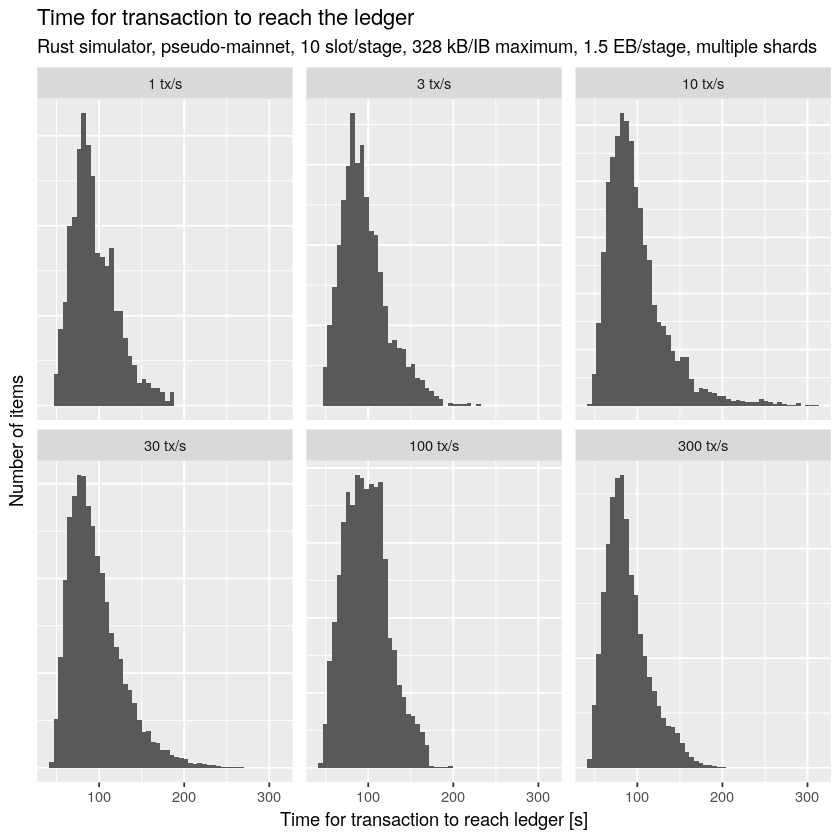

In [17]:
ggplot(
    lifecycle[
        `Kind` == "TX" & 
        !is.na(`To RB [s]`) &
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach ledger [s]`=`To RB [s]`-`Created [s]`), 
        .(`Kind`, `tps`)
    ],
    aes(x=`Time to reach ledger [s]`)
) + geom_histogram(bins=50) +
    facet_wrap(. ~ `tps`, scales="free_y", ncol=3) +
    xlab("Time for transaction to reach ledger [s]") +
    ylab("Number of items") +
    ggtitle("Time for transaction to reach the ledger", label) +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [18]:
ggsave("plots/tps3x/reach-rb-tx.png", units="in", dpi=150, width=8, height=6)

In [19]:
ggsave("plots/tps3x/reach-rb-tx.svg", units="in", dpi=150, width=8, height=6)

#### Time to reach an EB

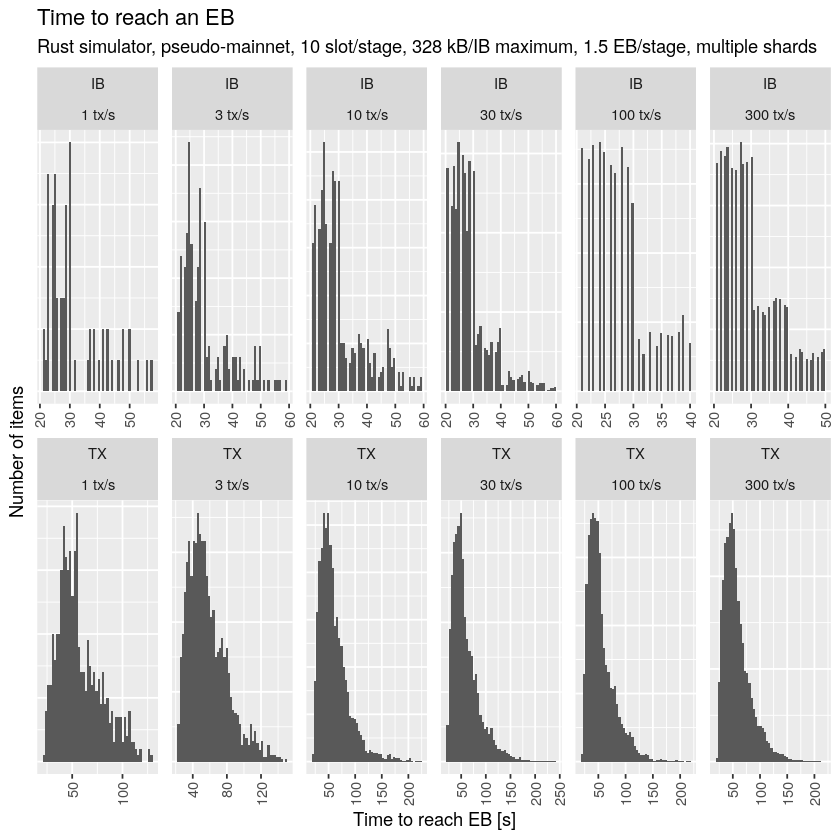

In [20]:
ggplot(
    lifecycle[
        `Kind` %in% c("TX", "IB") & 
        !is.na(`To EB [s]`) & 
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach EB [s]`=`To EB [s]`-`Created [s]`), 
        .(`Kind`, `tps`)
    ],
    aes(x=`Time to reach EB [s]`)
) + geom_histogram(bins=50) +
    facet_wrap(`Kind` ~ `tps`, scales="free", ncol=6) +
    ylab("Number of items") +
    ggtitle("Time to reach an EB", label) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [21]:
ggsave("plots/tps3x/reach-eb.png", units="in", dpi=150, width=8, height=6)

In [22]:
ggsave("plots/tps3x/reach-eb.svg", units="in", dpi=150, width=8, height=6)

#### Time to reach an IB

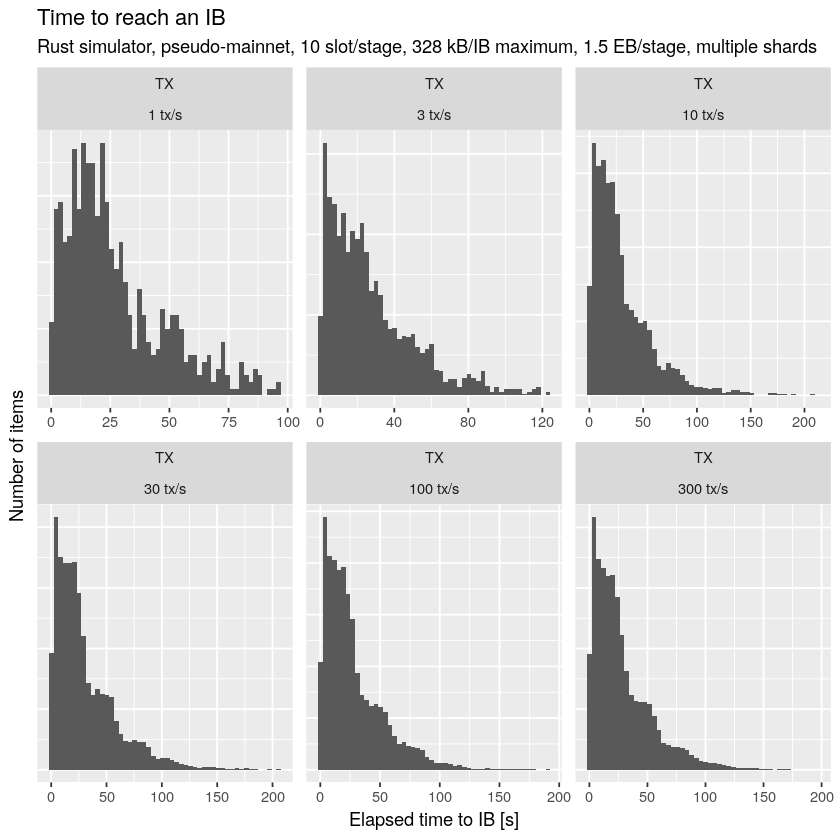

In [23]:
ggplot(
    lifecycle[
        `Kind` %in% c("TX") & 
        !is.na(`To IB [s]`) & 
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Elapsed time to IB [s]`=`To IB [s]`-`Created [s]`), 
        .(`Kind`, `tps`)],
    aes(x=`Elapsed time to IB [s]`)
) + geom_histogram(bins=50) +
    facet_wrap(`Kind` ~ `tps`, scales="free", ncol=3) +
    ylab("Number of items") +
    ggtitle("Time to reach an IB", label) +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [24]:
ggsave("plots/tps3x/reach-ib.png", units="in", dpi=150, width=8, height=6)

In [25]:
ggsave("plots/tps3x/reach-ib.svg", units="in", dpi=150, width=8, height=6)

#### Number of references

A *reference* is one of the following:

- A transaction is included in an IB.
- An IB is referenced by an EB.
- An EB is referenced by another EB.

In an efficient Leios, the number of references for each data item would be one.

- *Zero references* indicates that the item was not used.
- *Two or more references* indicates that duplication has occurred.

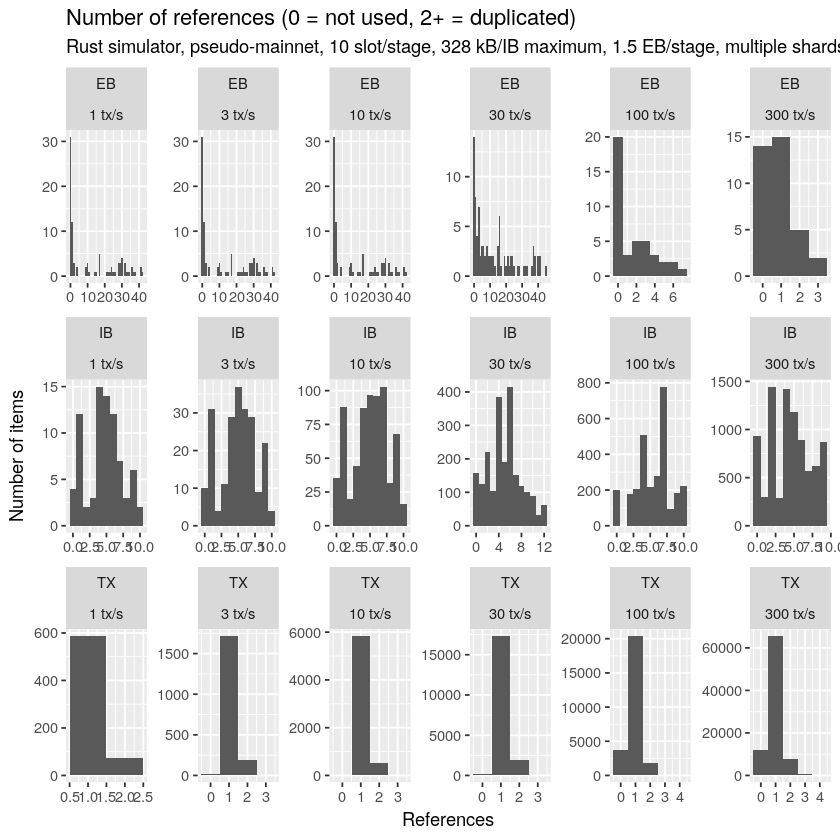

In [26]:
ggplot(
    lifecycle[
        `Kind` %in% c("TX", "IB", "EB")
    ], 
    aes(x=`References`)
) +
    geom_histogram(binwidth=1) +
    facet_wrap(`Kind` ~ `tps`, scales="free", ncol=6) +
    ylab("Number of items") +
    ggtitle("Number of references (0 = not used, 2+ = duplicated)", label)

In [27]:
ggsave("plots/tps3x/references.png", units="in", dpi=150, width=8, height=6)

In [28]:
ggsave("plots/tps3x/references.svg", units="in", dpi=150, width=8, height=6)

#### Temporal efficiency

In [29]:
toElapsed <- function(created, toRb, inRb) {
    if (!is.na(toRb))
        toRb - created
    else if (!is.na(inRb))
        inRb - created
    else
        NA
}

In [30]:
outcomes <- lifecycle[
    `Kind` == "TX",
    .(
        `Submitted [minute]`=factor(ceiling(`Created [s]`/60)), 
        `Time to reach ledger [s]`=mapply(toElapsed, `Created [s]`, `To RB [s]`, `In RB [s]`)
    ), .(
        `tps`
    )
][order(`tps`, `Submitted [minute]`, `Time to reach ledger [s]`)]

In [31]:
totals <- outcomes[, .(`Total`=.N, `Lost`=sum(is.na(`Time to reach ledger [s]`))), .(`tps`, `Submitted [minute]`)]

#### Transactions reaching the ledger

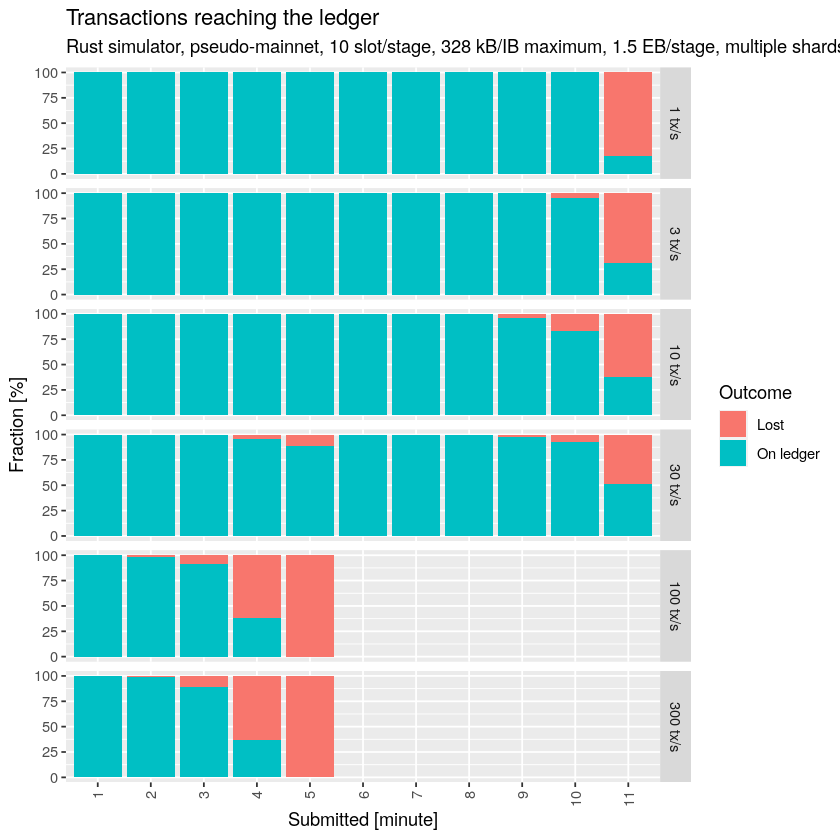

In [32]:
ggplot(
    melt(
        totals[, .(`On ledger`=1-`Lost`/`Total`, `Lost`=`Lost`/`Total`), .(`tps`, `Submitted [minute]`)],
        id.vars=c("tps", "Submitted [minute]"),
        variable.name="Outcome",
        value.name="Fraction"
    )[, .(
        `tps`, 
        `Submitted [minute]`, 
        `Outcome`=factor(`Outcome`,levels=c("Lost","On ledger")), 
        `Fraction [%]`=100*`Fraction`
    )],
    aes(x=`Submitted [minute]`, y=`Fraction [%]`, fill=`Outcome`)
) +
    geom_bar(stat="identity") +
    facet_grid(`tps` ~ .) +
    ggtitle("Transactions reaching the ledger", label) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [33]:
ggsave("plots/tps3x/temporal-efficiency-bar.png", units="in", dpi=150, width=8, height=6)

In [34]:
ggsave("plots/tps3x/temporal-efficiency-bar.svg", units="in", dpi=150, width=8, height=6)

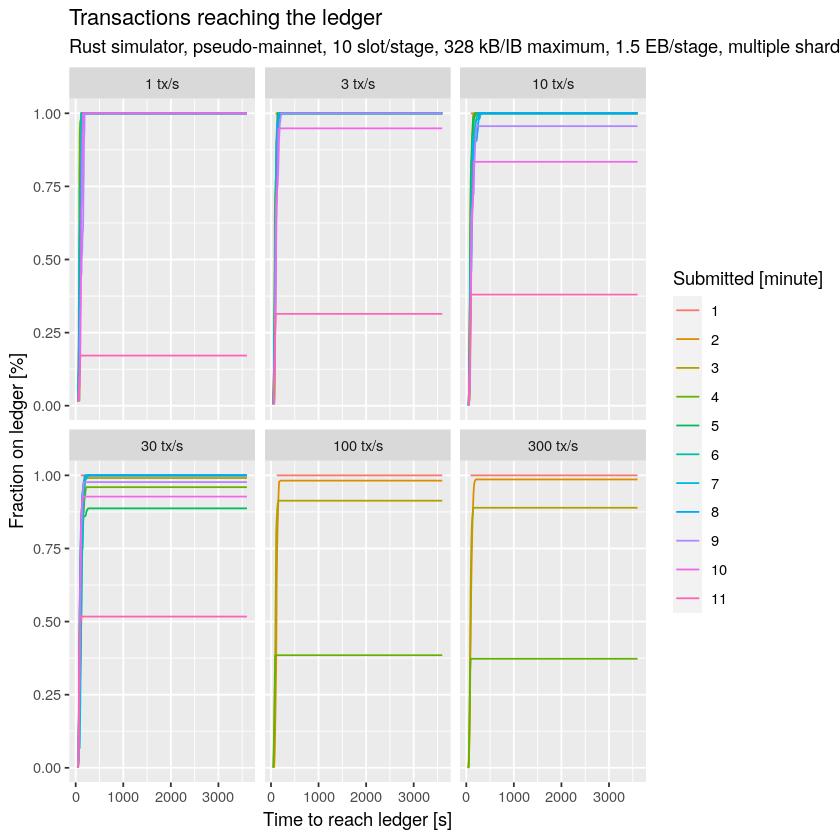

In [35]:
ggplot(
    rbind(
        totals[
            outcomes[!is.na(`Time to reach ledger [s]`), .(`Cumulative total`=1:length(`Time to reach ledger [s]`), `Time to reach ledger [s]`), .(`tps`, `Submitted [minute]`)],
            on=c("tps", "Submitted [minute]")
        ][,
            .(`Time to reach ledger [s]`, `Fraction on ledger [%]`=`Cumulative total`/`Total`),
            .(`tps`, `Submitted [minute]`)
        ],
        totals[, .(`Fraction on ledger [%]`=1-`Lost`/`Total`, `Time to reach ledger [s]`=3600), .(`tps`, `Submitted [minute]`)]
    )[`Submitted [minute]` != 0],
    aes(x=`Time to reach ledger [s]`, y=`Fraction on ledger [%]`, color=`Submitted [minute]`)
) +
    geom_line() +
    facet_wrap(`tps` ~ .) +
    ggtitle("Transactions reaching the ledger", label)

In [36]:
ggsave("plots/tps3x/temporal-efficiency-timeseries.png", units="in", dpi=150, width=8, height=6)

In [37]:
ggsave("plots/tps3x/temporal-efficiency-timeseries.svg", units="in", dpi=150, width=8, height=6)

#### Release memory

In [38]:
rm(lifecycle, outcomes, totals)

### Resource usage

In [39]:
resources <- fread("results/tps3x/resources.csv.gz", stringsAsFactors=TRUE)
resources %>% summary

 simulator         tps             Node         Egress [B]    Disk [B]     
 rust:60000   Min.   :  1   node-0   :    6   Min.   :0    Min.   :     0  
              1st Qu.:  3   node-1   :    6   1st Qu.:0    1st Qu.:     0  
              Median : 20   node-10  :    6   Median :0    Median :     0  
              Mean   : 74   node-100 :    6   Mean   :0    Mean   :  4085  
              3rd Qu.:100   node-1000:    6   3rd Qu.:0    3rd Qu.:     0  
              Max.   :300   node-1001:    6   Max.   :0    Max.   :995166  
                            (Other)  :59964                                
 Total CPU [s]    Maximum CPU [s/s]
 Min.   : 34.62   Min.   :0.6241   
 1st Qu.: 44.97   1st Qu.:1.1162   
 Median :133.89   Median :1.2222   
 Mean   :201.43   Mean   :1.6997   
 3rd Qu.:217.79   3rd Qu.:1.8984   
 Max.   :645.69   Max.   :3.9708   
                                   

In [ ]:
ggplot(
    resources[, .(`TX/s`=factor(`tps`), `Node`, `Nodal egress [MB/s]`=`Egress [B]`/txWindow/1e6)], 
    aes(x=`TX/s`, y=`Nodal egress [MB/s]`)
) +
    geom_violin() +
    ggtitle("Network", label)

In [ ]:
ggsave("plots/tps3x/network.png", units="in", dpi=150, width=9.5, height=5.5)

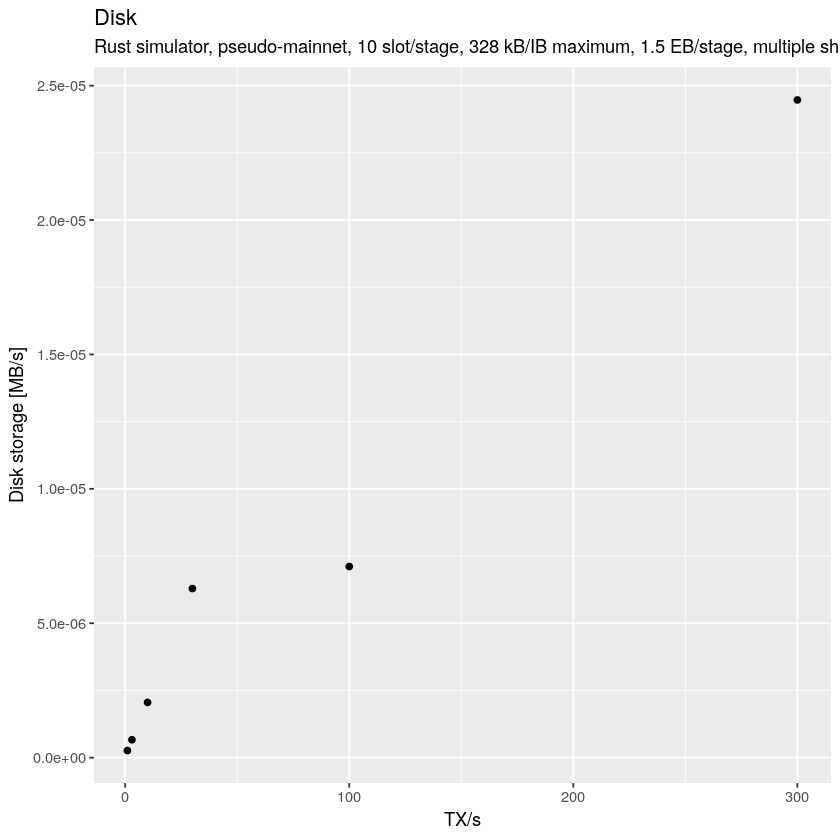

In [40]:
ggplot(
    resources[, .(`Disk storage [MB/s]`=mean(`Disk [B]`)/txWindow/1e6), .(`TX/s`=`tps`)],
    aes(x=`TX/s`, y=`Disk storage [MB/s]`)
) +
    geom_point() +
    ggtitle("Disk", label)

In [41]:
ggsave("plots/tps3x/disk.png", units="in", dpi=150, width=9.5, height=5.5)

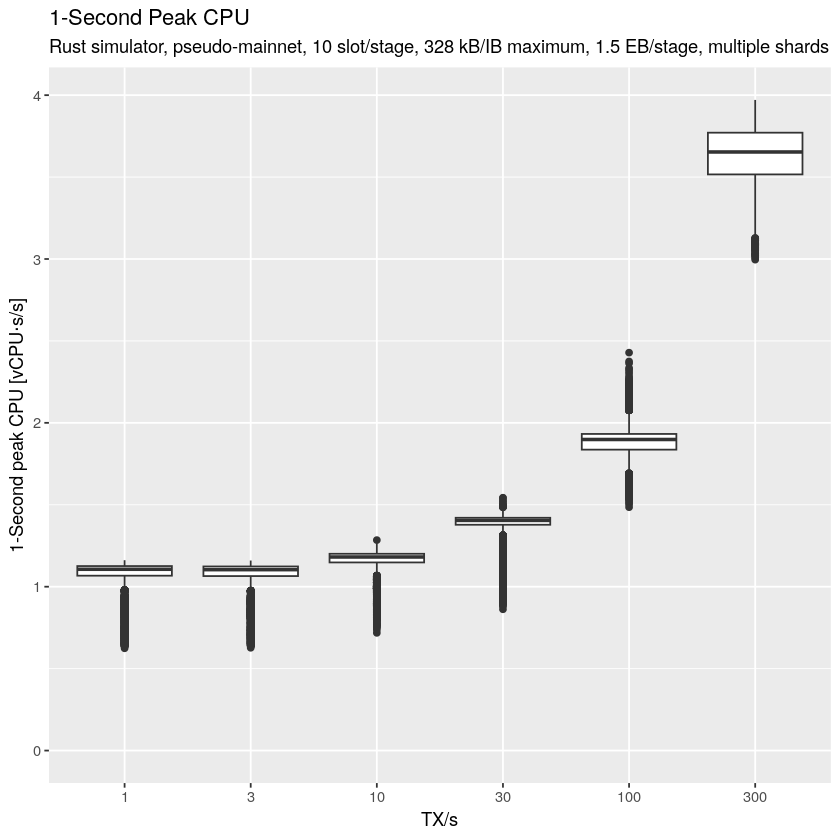

In [42]:
ggplot(
    resources[, .(`Node`, `TX/s`=factor(`tps`), `1-Second peak CPU [vCPU⋅s/s]`=`Maximum CPU [s/s]`)], 
    aes(x=`TX/s`, y=`1-Second peak CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    ggtitle("1-Second Peak CPU", label)

In [43]:
ggsave("plots/tps3x/cpu-peak.png", units="in", dpi=150, width=9.5, height=5.5)

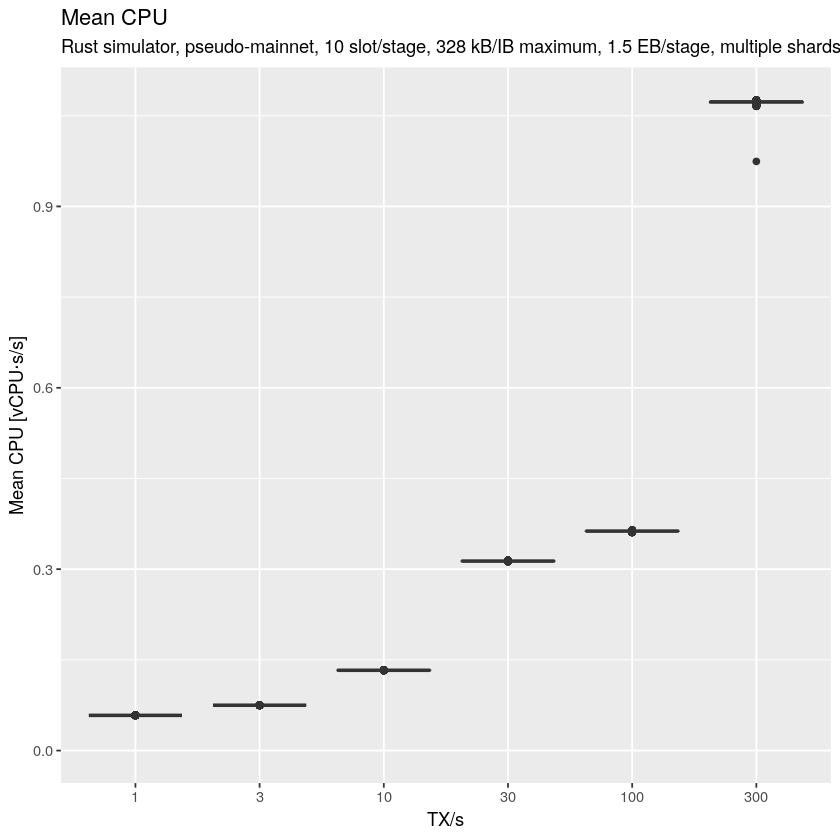

In [44]:
ggplot(
    resources[, .(`TX/s`=factor(`tps`), `Node`, `Mean CPU [vCPU⋅s/s]`=`Total CPU [s]`/txWindow
        )
    ], aes(x=`TX/s`, y=`Mean CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    ggtitle("Mean CPU", label)

In [45]:
ggsave("plots/tps3x/cpu-mean.png", units="in", dpi=150, width=9.5, height=5.5)

#### Release memory

In [46]:
rm(resources)

### Receipt of messages

#### Read results

In [47]:
receipts <- fread("results/tps3x/receipts-2%sample.csv.gz", stringsAsFactors=TRUE)
receipts %>% summary

 simulator            tps         Kind                     Item         
 rust:22976031   Min.   :  1.00   EB:   87823   240-node-7200:    1839  
                 1st Qu.:  3.00   IB: 2892336   250-node-165 :    1795  
                 Median : 30.00   RB:   34041   150-node-6681:    1633  
                 Mean   : 57.46   TX: 5679144   260-node-661 :    1601  
                 3rd Qu.: 30.00   VT:14282687   70-node-6648 :    1565  
                 Max.   :300.00                 120-node-7191:    1554  
                                                (Other)      :22966044  
      Producer        Generated [s]        Recipient         Received [s]    
 node-1   :   51643   Min.   :  0.13   node-3135:    2472   Min.   :  0.132  
 node-6996:   49301   1st Qu.:160.00   node-8275:    2472   1st Qu.:160.158  
 node-661 :   48891   Median :282.72   node-559 :    2471   Median :283.340  
 node-6437:   48843   Mean   :323.24   node-767 :    2466   Mean   :323.671  
 node-679 :   48679   3rd 

In [48]:
sampling <- 0.02

In [49]:
tpsLevels <- paste(receipts[, sort(unique(`tps`), decreasing=TRUE)], "tx/s")
tpsFactor <- function(tps) factor(paste(tps, "tx/s"), levels=tpsLevels)

In [50]:
kinds <- receipts[, unique(`Kind`) %>% sort]
kinds

[1] EB IB RB TX VT
Levels: EB IB RB TX VT

#### Arrival histograms

##### Compare the distributions of elapsed times

In [51]:
arrivalDelayHistogram <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[, .(`simulator`, `TPS`=tpsFactor(`tps`), `Elapsed [s]`)],
        aes(x=`Elapsed [s]`)
    ) +
        geom_histogram(binwidth=0.1) +
        facet_grid(`TPS` ~ `simulator`, scales=scales) +
        coord_cartesian(xlim=c(0, 3)) +
        xlab("Time from generation to receipt at node [s]") +
        ylab("Number received") +
        ggtitle(title, subtitle=label) +
        theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

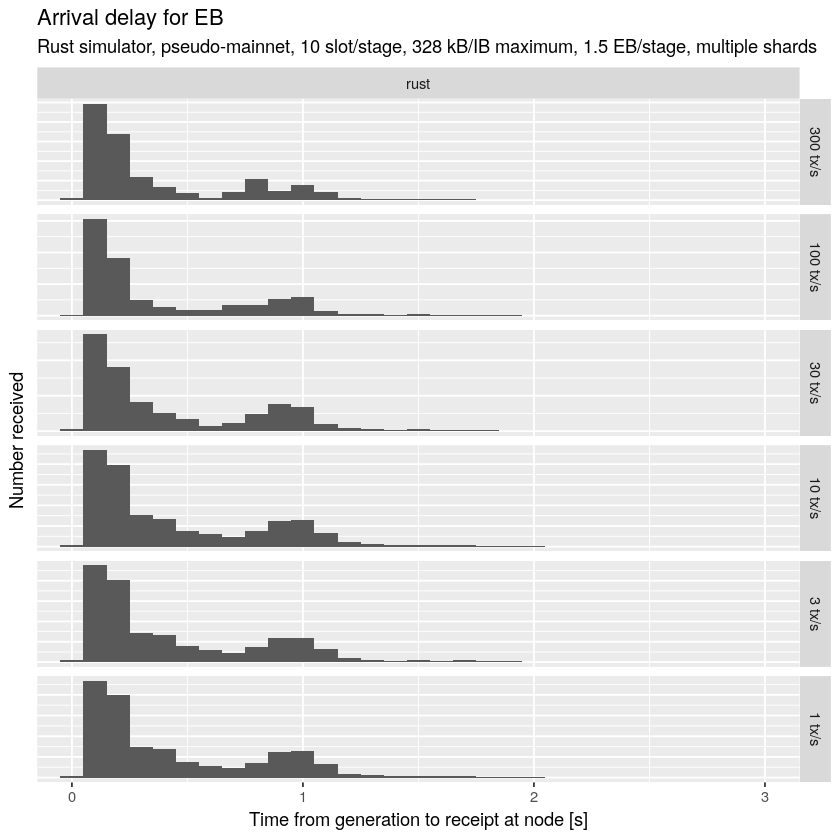

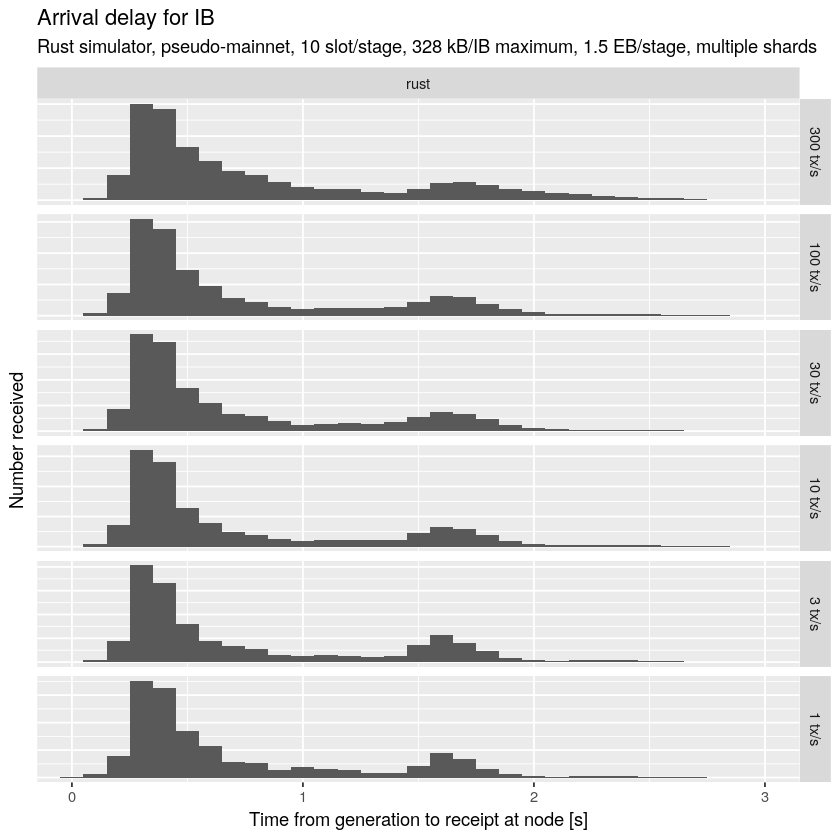

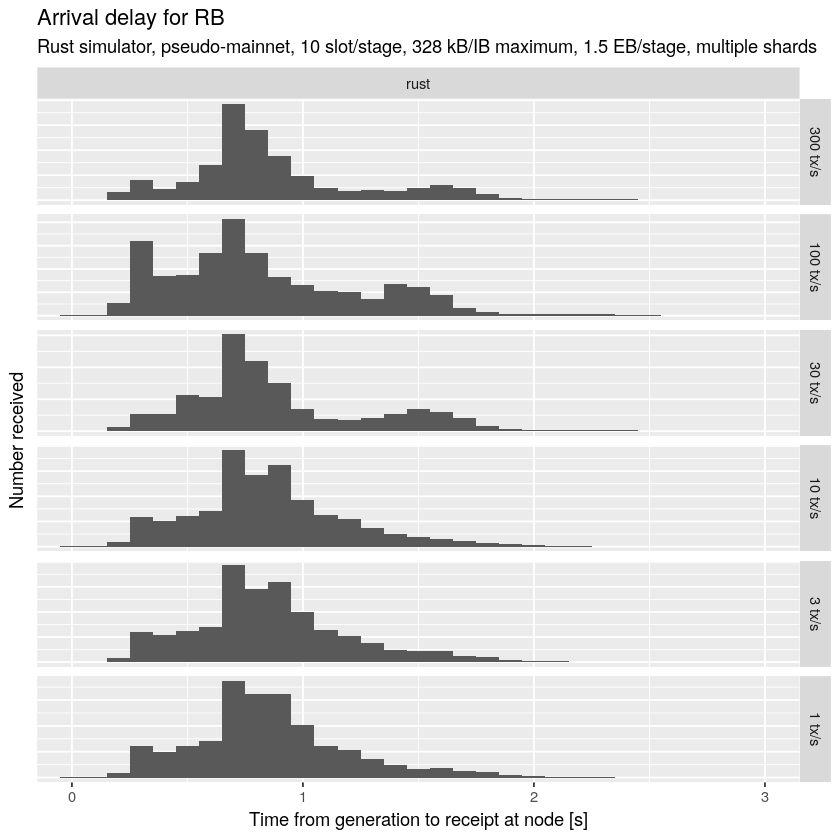

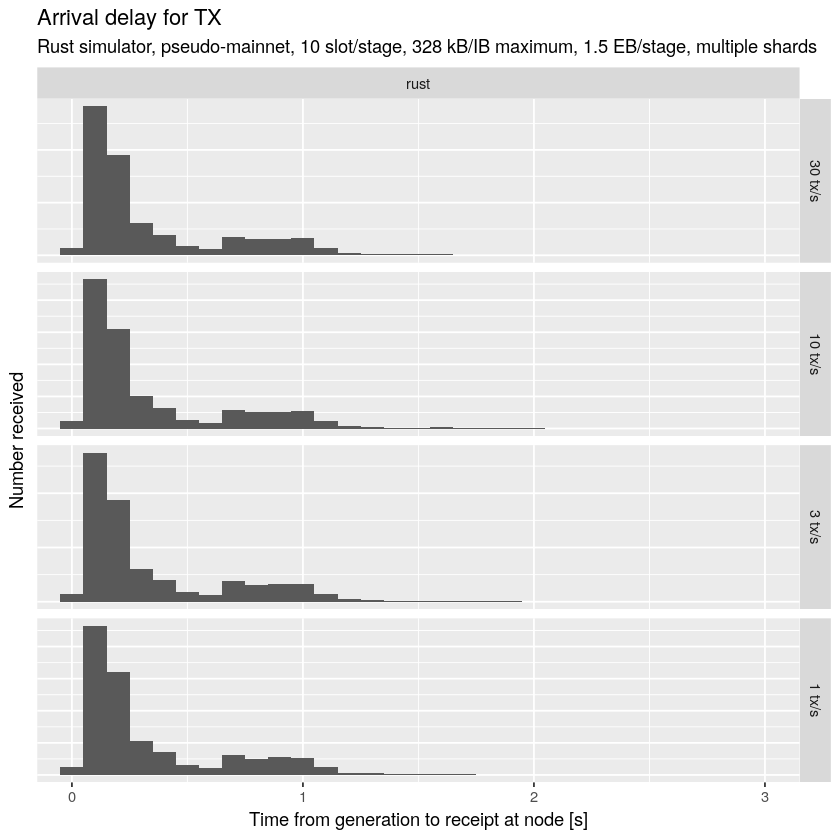

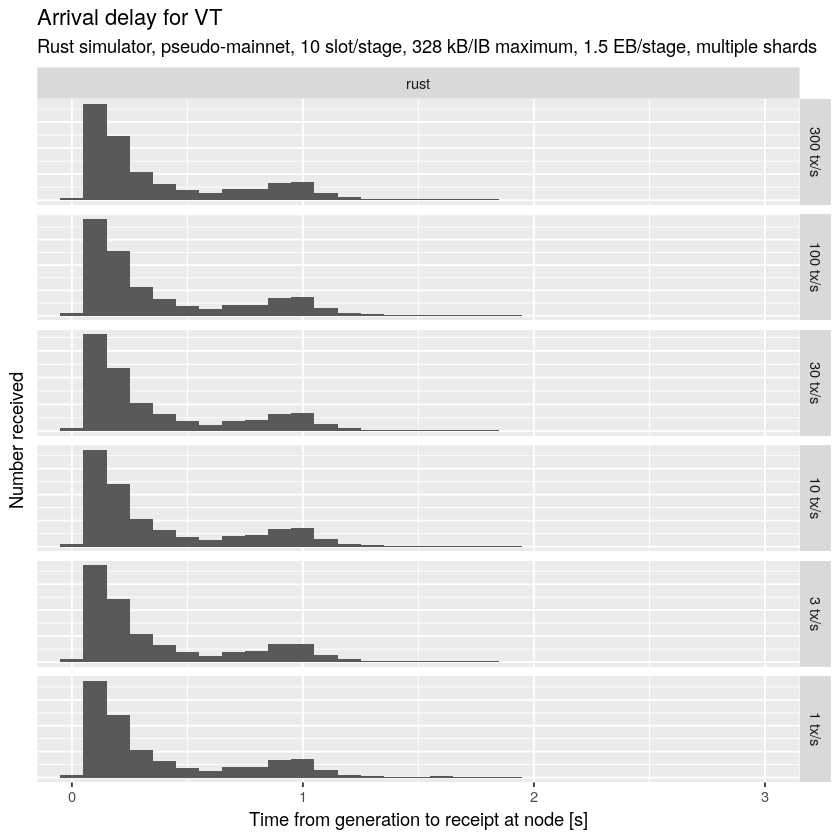

In [52]:
for (k in kinds)
    arrivalDelayHistogram(
        receipts[`Kind` == k],
        paste("Arrival delay for", k),
        scales="free_y",
        outfiles=paste0("plots/tps3x/elapsed-", k, ".png")
    ) %>% print

#### Fraction of items arriving

In [53]:
arrivalFractionTimeseries <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(`Received`=as.numeric(.N)/sampling),
            by=.(`simulator`, `tps`, `Generated [s]`, `Item`)
        ][,
            .(`Total`=as.numeric(.N), `Received`=sum(`Received`)),
            by=.(`simulator`, `tps`, `Generated [s]`)
        ][,
            .(`Received`=sum(`Received`)/sum(`Total`)),
            by=.(`simulator`, `tps`, `Generated [s]`)
        ][, .(
                `simulator`,
                `TPS`=tpsFactor(`tps`),
                `Generated [s]`,
                `Received`
        )], 
        aes(x=`Generated [s]`, y=`Received`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`TPS`  ~ `simulator`, scales=scales) +
        xlab("Time of generation [s]") +
        ylab("Number of nodes receiving") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

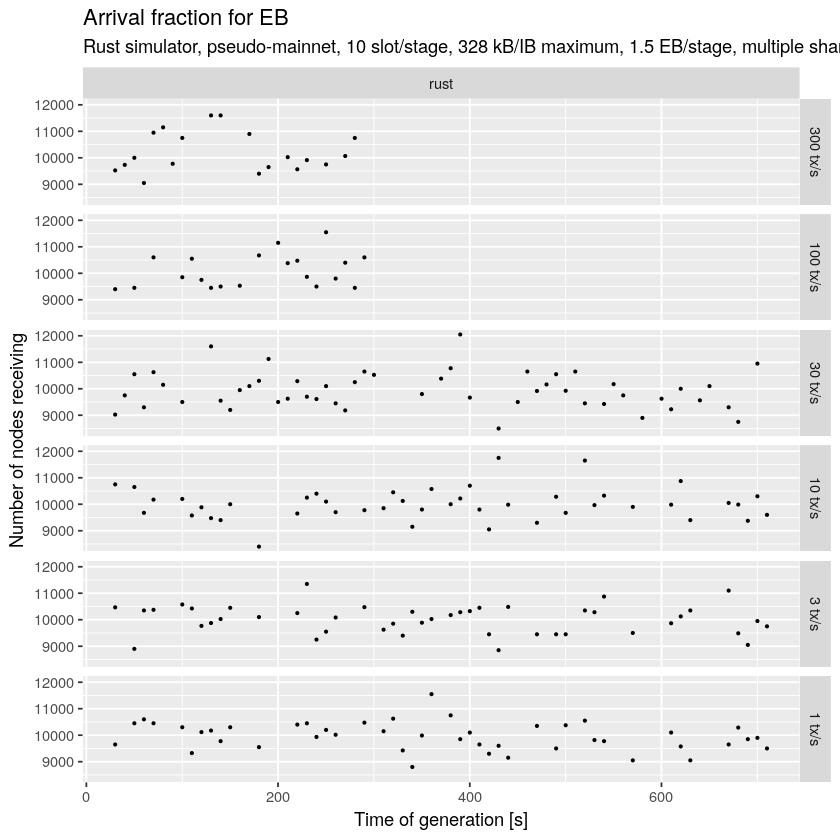

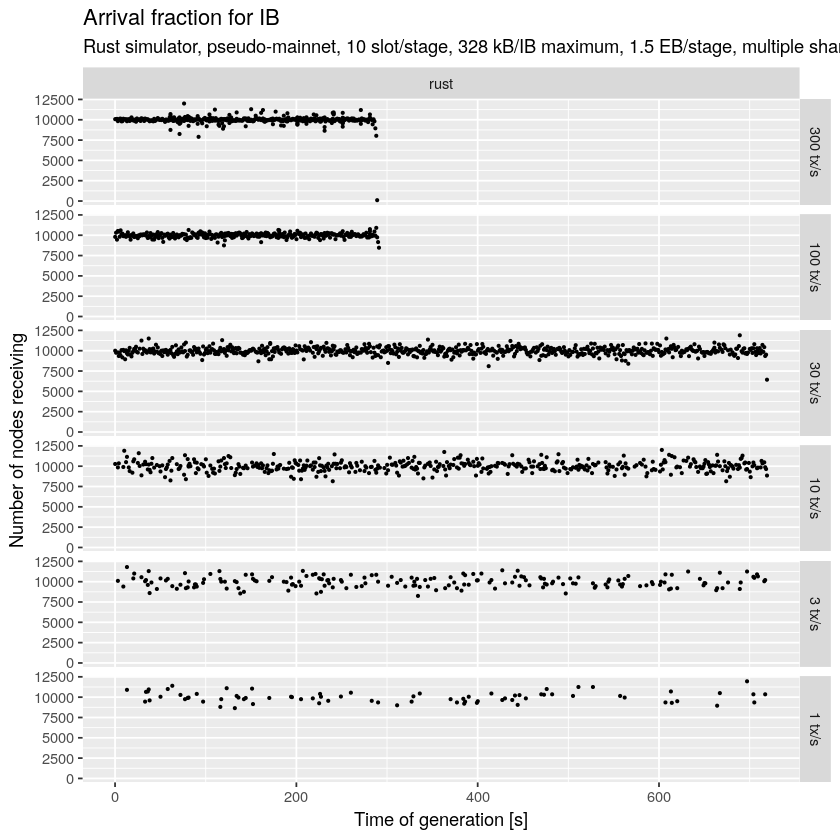

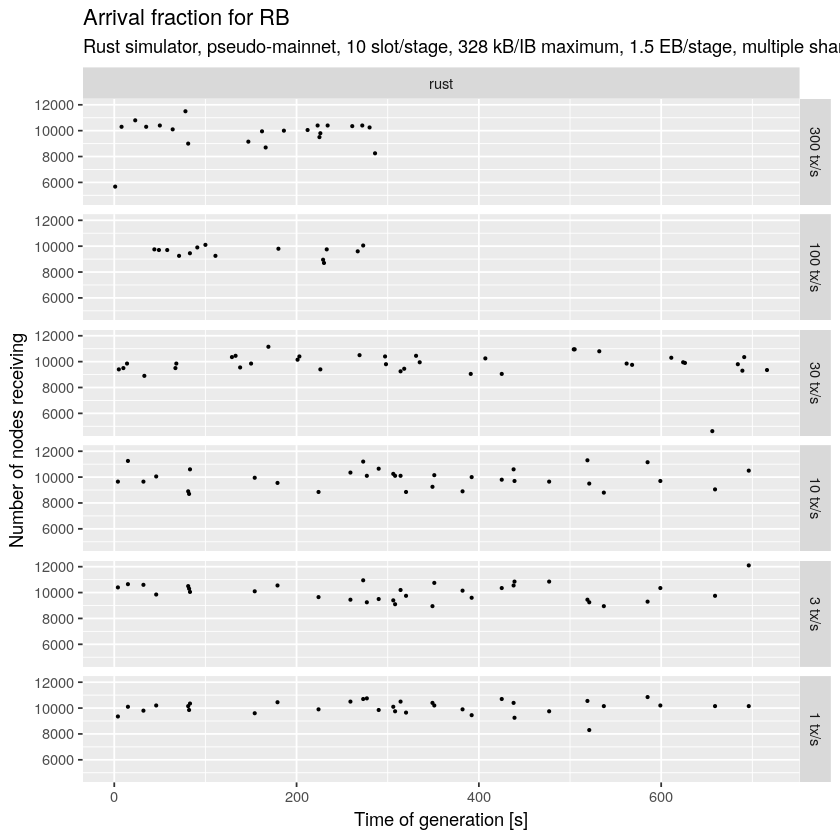

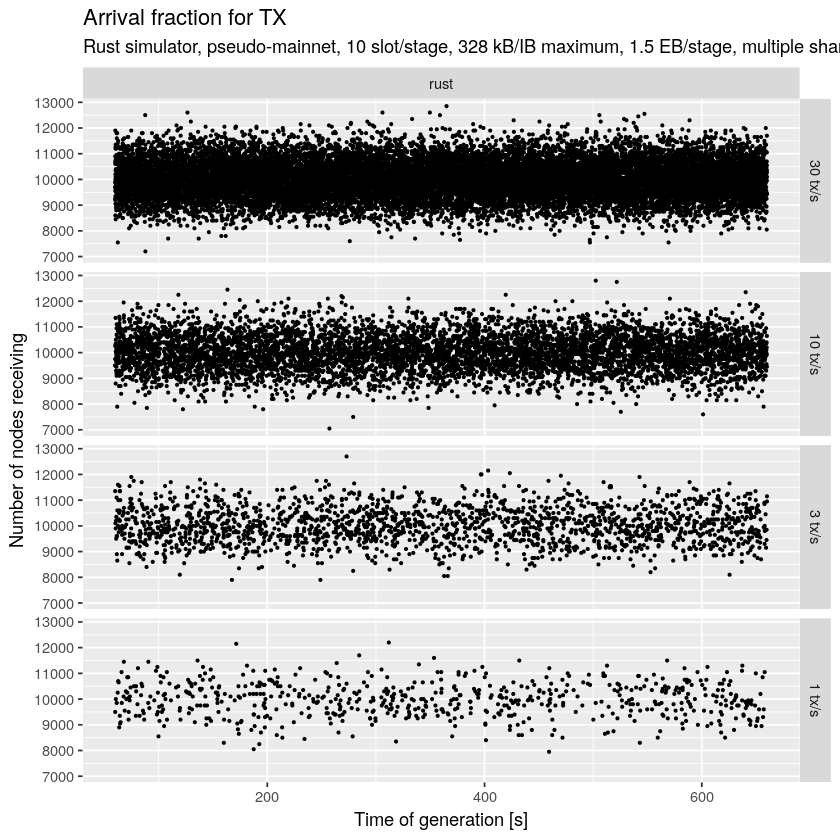

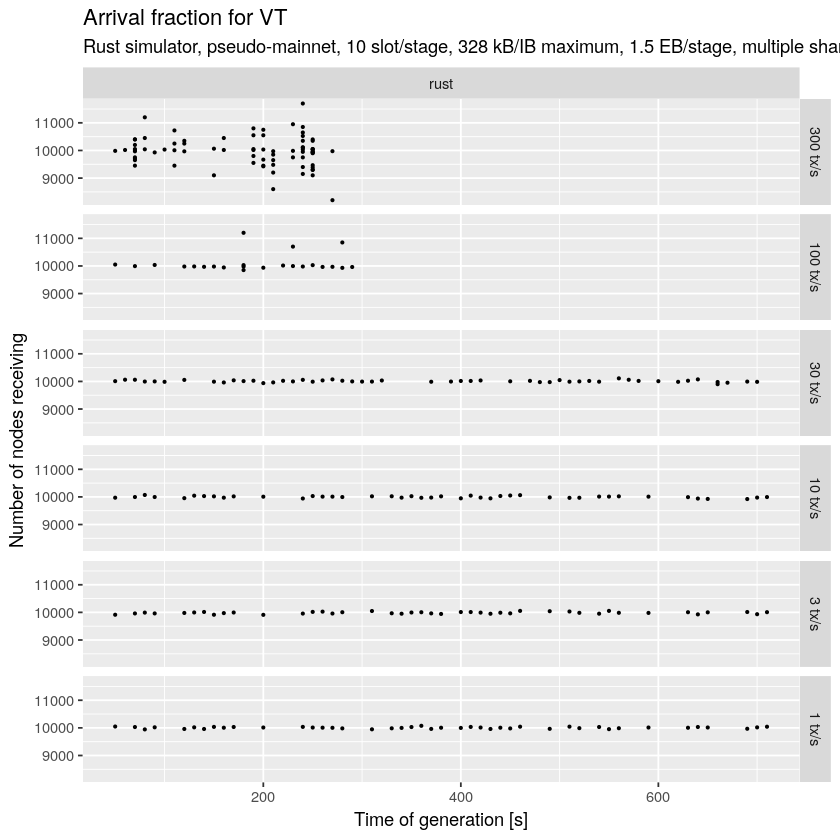

In [54]:
for (k in kinds)
    arrivalFractionTimeseries(
        receipts[`Kind` == k],
        paste("Arrival fraction for", k),
        outfiles=paste0("plots/tps3x/arrival-", k, ".png")
    ) %>% print

#### Bandwidth usage

##### Total network bandwidth

In [ ]:
totalBandwidthPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `Size [GB]`=sum(`Size [B]`, rm.na=TRUE)/1e9
            ),
            by=.(
                `Simulator`,
                `TPS`=tpsFactor(`TPS`),
                `Slot`=floor(`Received [s]`),
                `Message`=`Kind`
            )
        ],
        aes(x=`Slot`, y=`Size [GB]`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`TPS` ~ `Simulator`, scales=scales) +
        scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Total network ingress [GB/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

In [ ]:
totalBandwidthPlot(
    receipts,
    "Total bandwidth",
    outfiles=paste0("plots/tps/ingress-total-area.png")
)

##### Bandwidth usage per node

In [55]:
nodeCount <- receipts[, length(unique(`Recipient`))]
nodeCount

[1] 10000

In [ ]:
meanNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `Size [MB/node]`=sum(`Size [B]`)/1e6 / nodeCount
            ),
            by=.(
                `Simulator`,
                `TPS`=tpsFactor(`TPS`),
                `Slot`=floor(`Received [s]`),
                `Message`=`Kind`
            )
        ],
        aes(x=`Slot`, y=`Size [MB/node]`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`TPS` ~ `Simulator`, scales=scales) +
        scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Mean network ingress among nodes [MB/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

In [ ]:
meanNodalIngressPlot(
    receipts, 
    "Mean nodal ingress",
    outfiles=paste0("plots/tps/ingress-average-area.png")
)

In [ ]:
peakNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `Size [MB]`=sum(`Size [B]`, rm.na=TRUE)/1e6
            ),
            by=.(
                `Simulator`,
                `TPS`=tpsFactor(`TPS`),
                `Slot`=floor(`Received [s]`),
                `Message`=`Kind`,
                `Recipient`
            )
        ][,
            .(`Size [MB]`=max(`Size [MB]`)),
            by=.(`Simulator`, `TPS`, `Slot`, `Message`)
        ],
        aes(x=`Slot`, y=`Size [MB]`, color=`Message`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`TPS` ~ `Simulator`, scales=scales) +
        scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Maximum network ingress among nodes [MB/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

In [ ]:
peakNodalIngressPlot(
    receipts, 
    "Peak nodal ingress",
    outfiles=paste0("plots/tps/ingress-peak-point.png")
)

#### Release memory

In [56]:
rm(receipts)

### CPU usage

#### Read results

In [57]:
cpus <- fread("results/tps3x/cpus-2%sample.csv.gz", stringsAsFactors=TRUE)
cpus %>% summary

 simulator            tps           Slot              Node         
 rust:30798881   Min.   :  1   Min.   :  0.0   node-1158:    3319  
                 1st Qu.:  3   1st Qu.:206.0   node-1187:    3290  
                 Median : 10   Median :370.0   node-2713:    3276  
                 Mean   : 16   Mean   :367.5   node-4518:    3275  
                 3rd Qu.: 30   3rd Qu.:520.0   node-1703:    3272  
                 Max.   :300   Max.   :720.0   node-2693:    3264  
                                               (Other)  :30779185  
      Task           Duration [s]     
 ValVote:23429107   Min.   :0.000164  
 ValTX  : 5764051   1st Qu.:0.000816  
 ValIB  :  744264   Median :0.000816  
 ValIH  :  743671   Mean   :0.007866  
 ValEB  :   80886   3rd Qu.:0.000816  
 ValRB  :   34084   Max.   :2.759708  
 (Other):    2818                     

In [58]:
cpusNode <-
cpus[
    ,
    .(
        `Duration [s]`=sum(`Duration [s]`)
    ),
    by=.(
        `simulator`,
        `TPS`=tpsFactor(`tps`),
        `Node`,
        `Slot`
    )
]

#### Peak CPU usage

##### Histogram

In [59]:
peakCpuHistogram <- function(cs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(
                `Duration [%]`=100*max(`Duration [s]`)
            ),
            by=.(
                `simulator`,
                `TPS`,
                `Slot`
            )
        ], 
        aes(x=`Duration [%]`)
    ) +
        geom_histogram(binwidth=10) +
        facet_grid(`TPS` ~ `simulator`, scales=scales) +
      # coord_cartesian(xlim=c(0, 700)) +
        xlab("Peak CPU load [%]") +
        ylab("Number of slots") +
        ggtitle(title, subtitle="label")
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

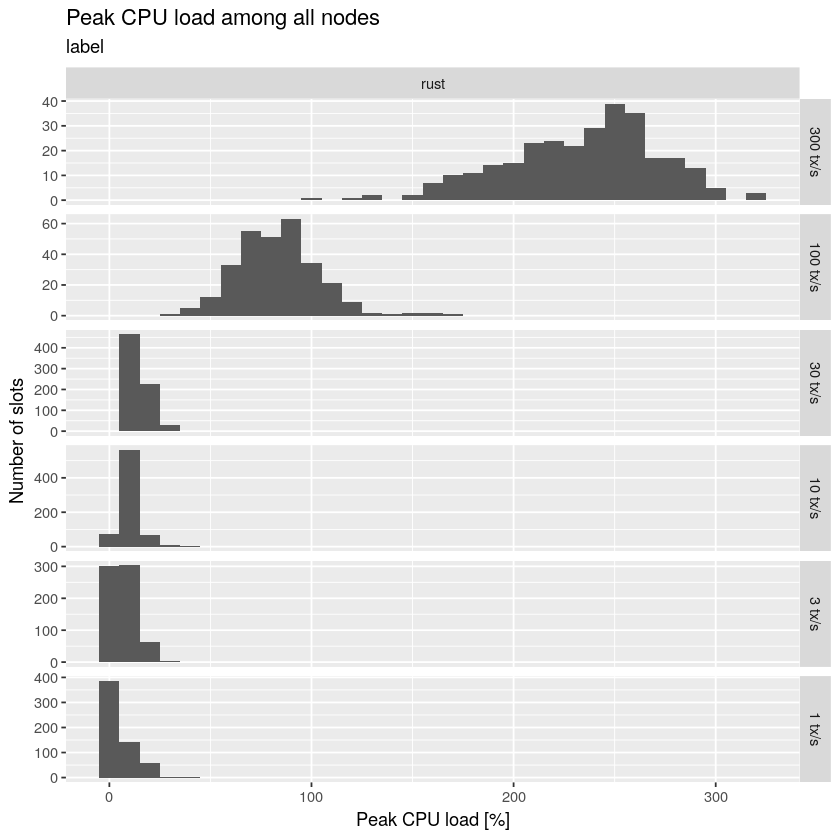

In [60]:
peakCpuHistogram(
    cpusNode, 
    "Peak CPU load among all nodes",
    scales="free_y",
    outfiles=paste0("plots/tps3x/cpu-peak-histogram.png")
)

##### Time series

In [61]:
peakCpuTimeseries <- function(cs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(
                `Duration [%]`=100*mean(`Duration [s]`)
            ),
            by=.(
                `simulator`,
                `TPS`,
                `Slot`
            )
        ], 
        aes(x=`Slot`, y=`Duration [%]`)) +
        geom_line() +
        facet_grid(`TPS` ~ `simulator`, scale=scales) +
        scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

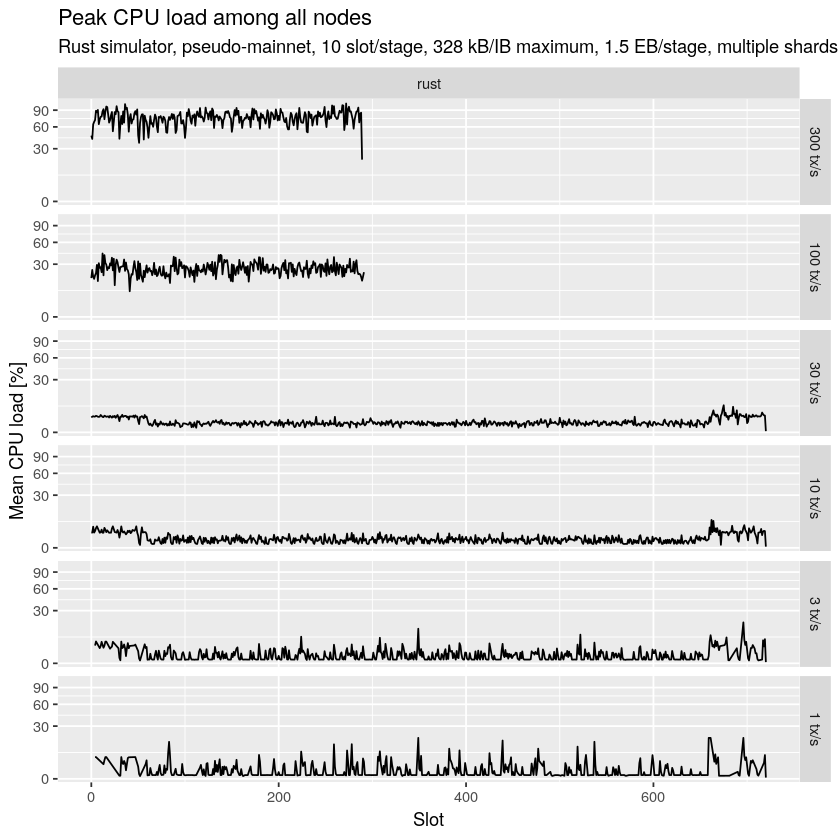

In [62]:
peakCpuTimeseries(
    cpusNode,
    "Peak CPU load among all nodes",
    outfiles=paste0("plots/tps3x/cpu-peak-timeseries.png")
)

#### Mean CPU usage

##### Histogram

In [63]:
meanCpuHistogram <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(
                `Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds/sampling
            ),
            by=.(
                `simulator`,
                `TPS`=tpsFactor(`tps`),
                `Task`
            )
        ], 
        aes(x="", fill=`Task`, y=`Duration [%]`)) +
        geom_bar(stat = "identity") +
        facet_grid(`TPS` ~ `simulator`, scales=scales) +
        xlab("") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

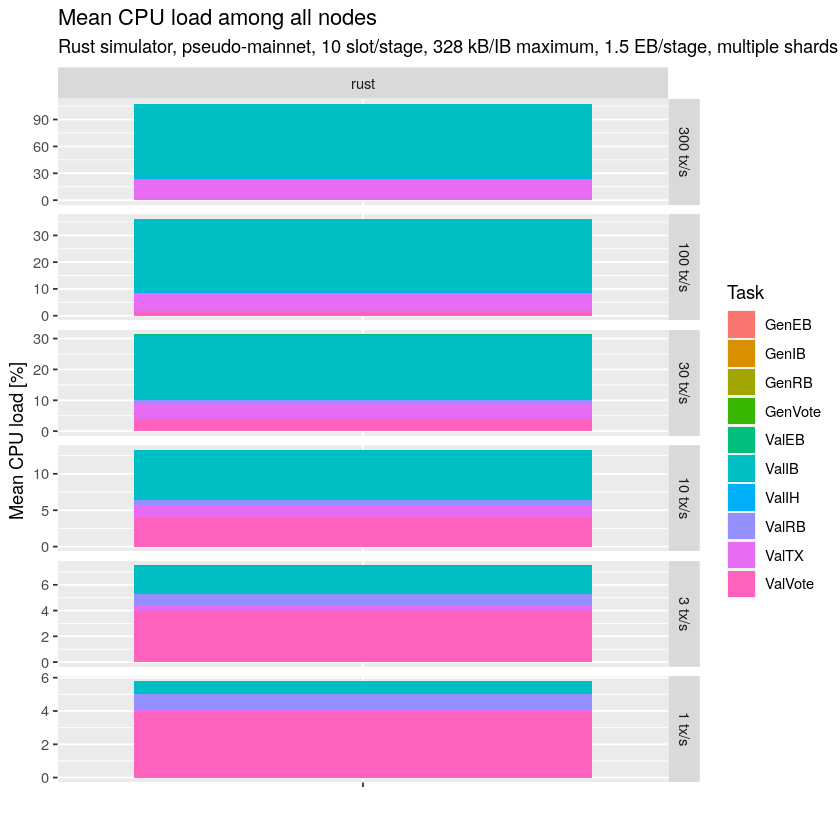

In [64]:
meanCpuHistogram(
    cpus,
    nodeCount * txWindow, 
    "Mean CPU load among all nodes", 
    scales="free_y",
    outfiles=paste0("plots/tps3x/cpu-mean-histogram.png")
)

##### Time series

In [66]:
meanCpuTimeseries <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(
                `Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds/sampling
            ),
            by=.(
                `simulator`,
                `TPS`=tpsFactor(`tps`),
                `Slot`,
                `Task`
            )
        ], 
        aes(x=`Slot`, y=`Duration [%]`, color=`Task`)
    ) +
        geom_point(size=0.25, alpha=0.75) +
        facet_grid(`TPS` ~ `simulator`, scales=scales) +
        scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

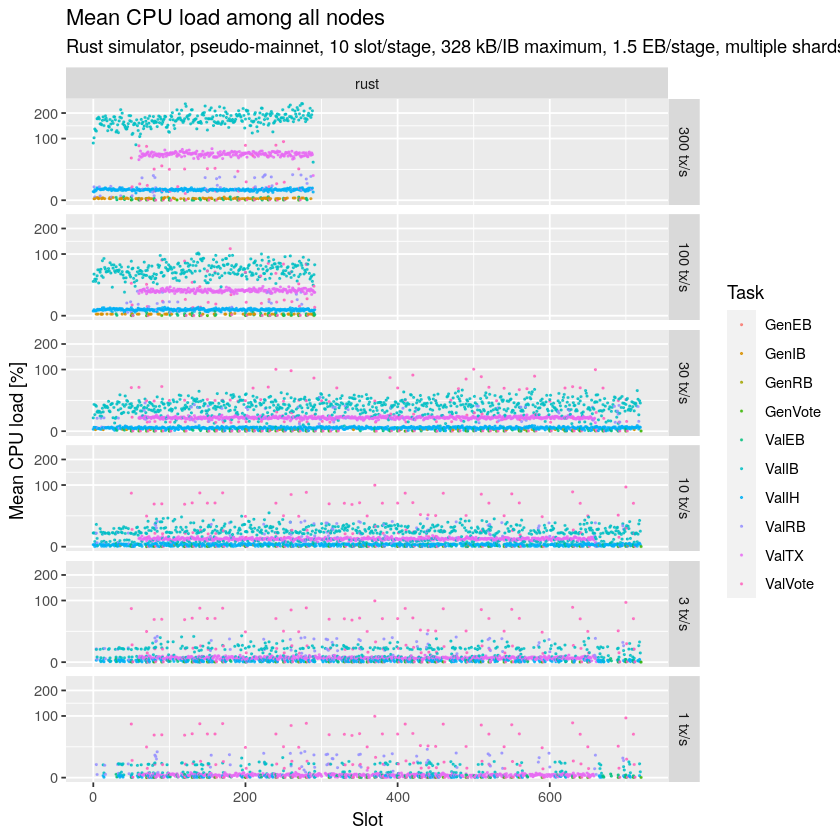

In [67]:
meanCpuTimeseries(
    cpus, 
    nodeCount, 
    "Mean CPU load among all nodes",
    outfiles=paste0("plots/tps3x/cpu-mean-timeseries.png")
)

#### Release memory

In [68]:
rm(cpus, cpusNode)

## IB Experiment

In [69]:
label <- "pseudo-mainnet, 10 slot/stage, 328 kB/IB maximum, 1.5 EB/stage, multiple shards"

### Resource usage

In [70]:
resources <- fread("results/ibs/resources.csv.gz", stringsAsFactors=TRUE)
resources %>% summary

 simulator         ibps               Node         Egress [B]    Disk [B]      
 rust:70000   Min.   : 0.500   node-0   :    7   Min.   :0    Min.   :      0  
              1st Qu.: 1.000   node-1   :    7   1st Qu.:0    1st Qu.:      0  
              Median : 4.000   node-10  :    7   Median :0    Median :      0  
              Mean   : 9.071   node-100 :    7   Mean   :0    Mean   :  53760  
              3rd Qu.:16.000   node-1000:    7   3rd Qu.:0    3rd Qu.:      0  
              Max.   :32.000   node-1001:    7   Max.   :0    Max.   :8270304  
                               (Other)  :69958                                 
 Total CPU [s]     Maximum CPU [s/s]
 Min.   :  42.31   Min.   :0.8676   
 1st Qu.:  62.77   1st Qu.:1.7753   
 Median : 202.17   Median :2.2373   
 Mean   : 384.95   Mean   :2.7401   
 3rd Qu.: 596.95   3rd Qu.:3.1396   
 Max.   :1448.88   Max.   :6.3388   
                                    

In [ ]:
ggplot(
    resources[, .(`simulator`, `IB/S`=factor(`ibps`), `Node`, `Nodal egress [MB/s]`=`Egress [B]`/600/1e6)], 
    aes(x=`IB/S`, y=`Nodal egress [MB/s]`)
) +
    geom_violin() +
    facet_grid(`simulator` ~ .) +
    ggtitle("Network", label)

In [ ]:
ggsave("plots/ibs/network.png", units="in", dpi=150, width=9.5, height=5.5)

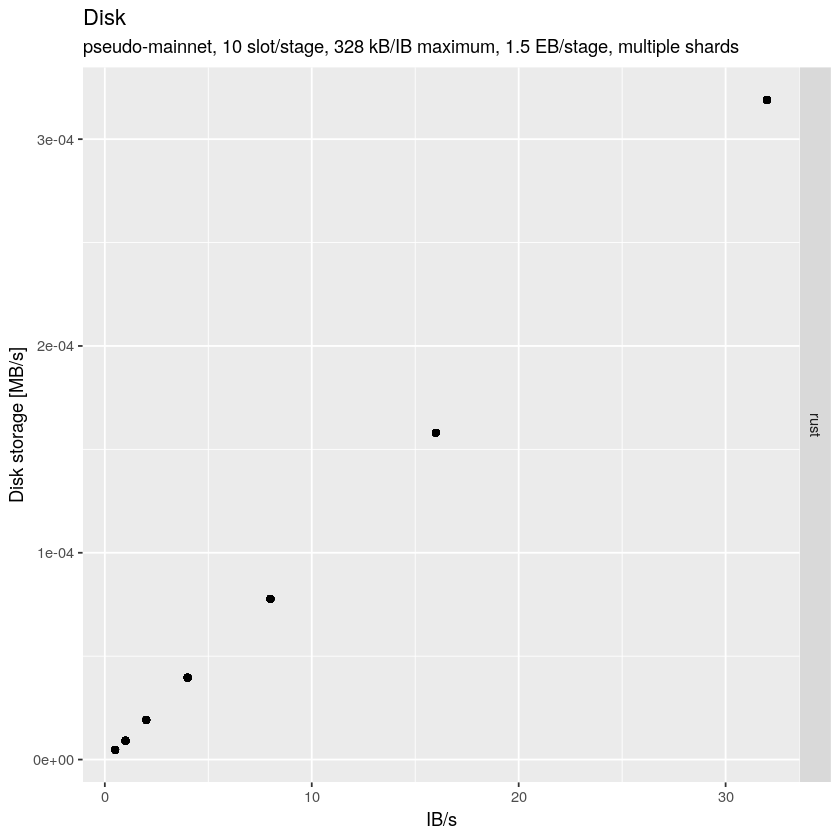

In [73]:
ggplot(
    resources[, .(`simulator`, `Disk storage [MB/s]`=mean(`Disk [B]`)/txWindow/1e6), .(`IB/s`=`ibps`)],
    aes(x=`IB/s`, y=`Disk storage [MB/s]`)
) +
    geom_point() +
    facet_grid(`simulator` ~ .) +
    ggtitle("Disk", label)

In [74]:
ggsave("plots/ibs/disk.png", units="in", dpi=150, width=9.5, height=5.5)

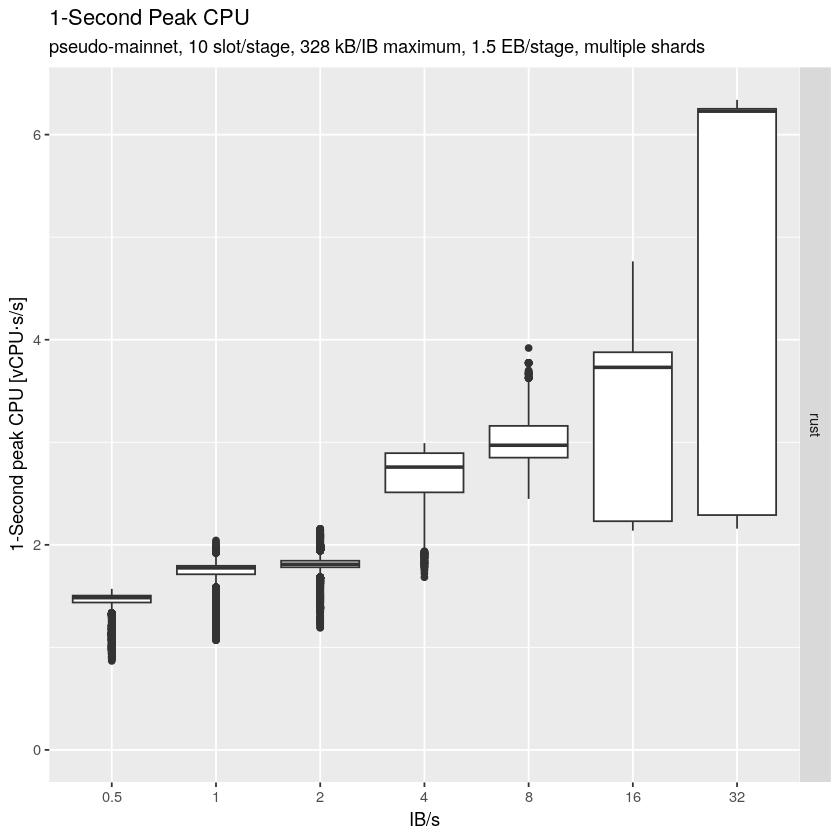

In [75]:
ggplot(
    resources[, .(`simulator`, `Node`, `IB/s`=factor(`ibps`), `1-Second peak CPU [vCPU⋅s/s]`=`Maximum CPU [s/s]`)], 
    aes(x=`IB/s`, y=`1-Second peak CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    facet_grid(`simulator` ~ .) +
    ggtitle("1-Second Peak CPU", label)

In [76]:
ggsave("plots/ibs/cpu-peak.png", units="in", dpi=150, width=9.5, height=5.5)

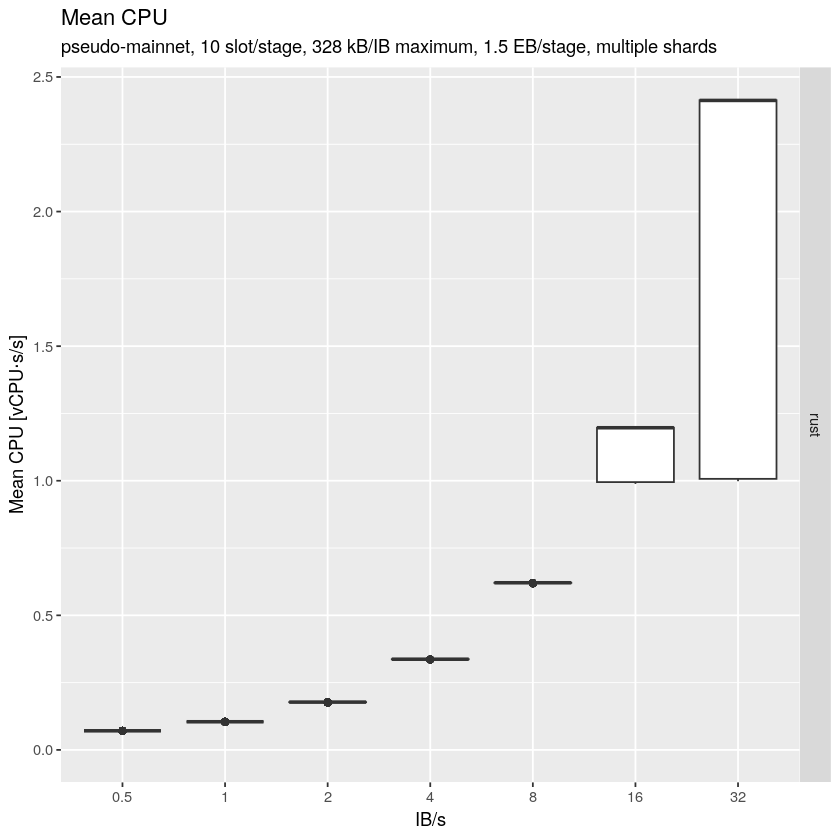

In [77]:
ggplot(
    resources[, .(`simulator`, `IB/s`=factor(`ibps`), `Node`, `Mean CPU [vCPU⋅s/s]`=`Total CPU [s]`/txWindow
        )
    ], aes(x=`IB/s`, y=`Mean CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    facet_grid(`simulator` ~ .) +
    ggtitle("Mean CPU", label)

In [78]:
ggsave("plots/ibs/cpu-mean.png", units="in", dpi=150, width=9.5, height=5.5)

#### Release memory

In [79]:
rm(resources)

### Receipt of messages

#### Read results

In [80]:
receipts <- fread("results/ibs/receipts-2%sample.csv.gz", stringsAsFactors=TRUE)
receipts %>% summary

 simulator            ibps        Kind                    Item         
 rust:11462779   Min.   : 0.500   EB: 100174   140-node-6646:    1639  
                 1st Qu.: 1.000   IB:3461089   90-node-6434 :    1573  
                 Median : 4.000   RB:  23550   70-node-795  :    1469  
                 Mean   : 8.529   VT:7877966   260-node-661 :    1461  
                 3rd Qu.: 8.000                210-node-6414:    1451  
                 Max.   :32.000                120-node-673 :    1447  
                                               (Other)      :11453739  
      Producer        Generated [s]        Recipient         Received [s]     
 node-0   :   38051   Min.   :  0.13   node-6390:    1307   Min.   :  0.1337  
 node-661 :   37055   1st Qu.:100.00   node-5905:    1299   1st Qu.:100.1352  
 node-684 :   36393   Median :160.00   node-9319:    1295   Median :160.9297  
 node-665 :   36271   Mean   :163.84   node-5803:    1291   Mean   :164.4740  
 node-6437:   35608   3rd Qu.

In [81]:
ibpsLevels <- paste(receipts[, sort(unique(`ibps`), decreasing=TRUE)], "IB/s")
ibpsFactor <- function(ibps) factor(paste(ibps, "IB/s"), levels=ibpsLevels)

In [82]:
kinds <- receipts[, unique(`Kind`) %>% sort]
kinds

[1] EB IB RB VT
Levels: EB IB RB VT

#### Arrival histograms

##### Compare the distributions of elapsed times

In [83]:
arrivalDelayHistogram <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[, .(`simulator`, `IB/s`=ibpsFactor(`ibps`), `Elapsed [s]`)],
        aes(x=`Elapsed [s]`)
    ) +
        geom_histogram(binwidth=0.1) +
        facet_grid(`IB/s` ~ `simulator`, scales=scales) +
        coord_cartesian(xlim=c(0, 3)) +
        xlab("Time from generation to receipt at node [s]") +
        ylab("Number received") +
        ggtitle(title, subtitle=label) +
        theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

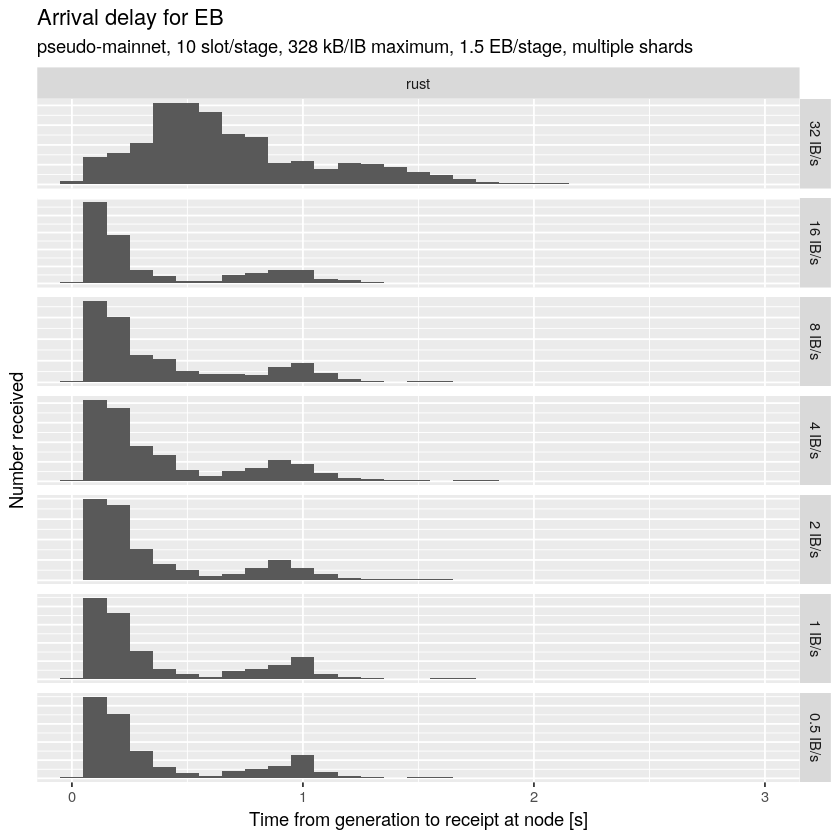

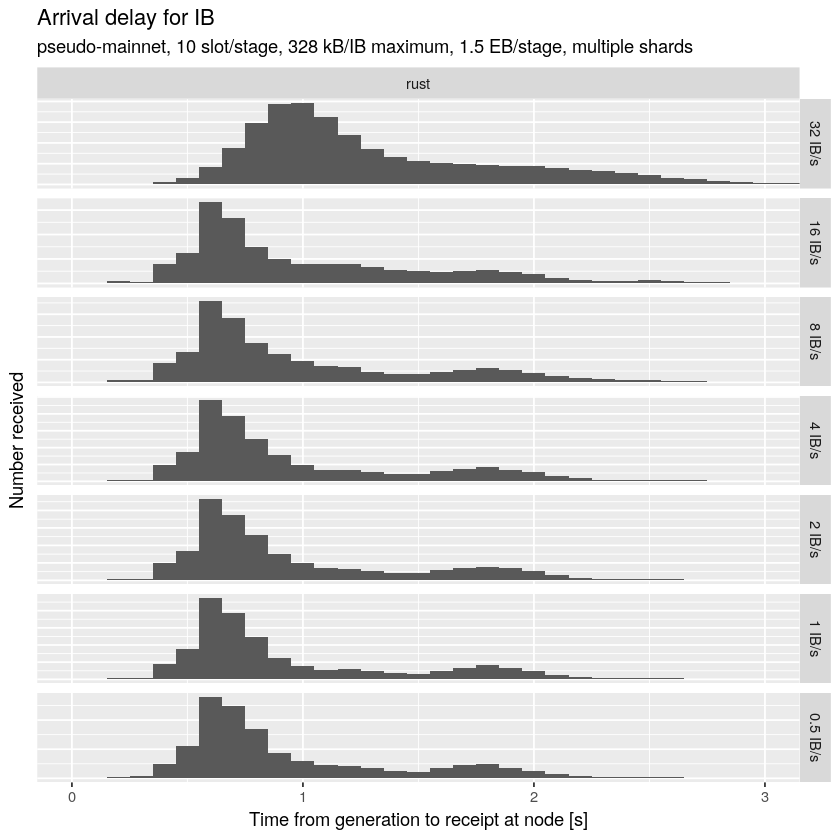

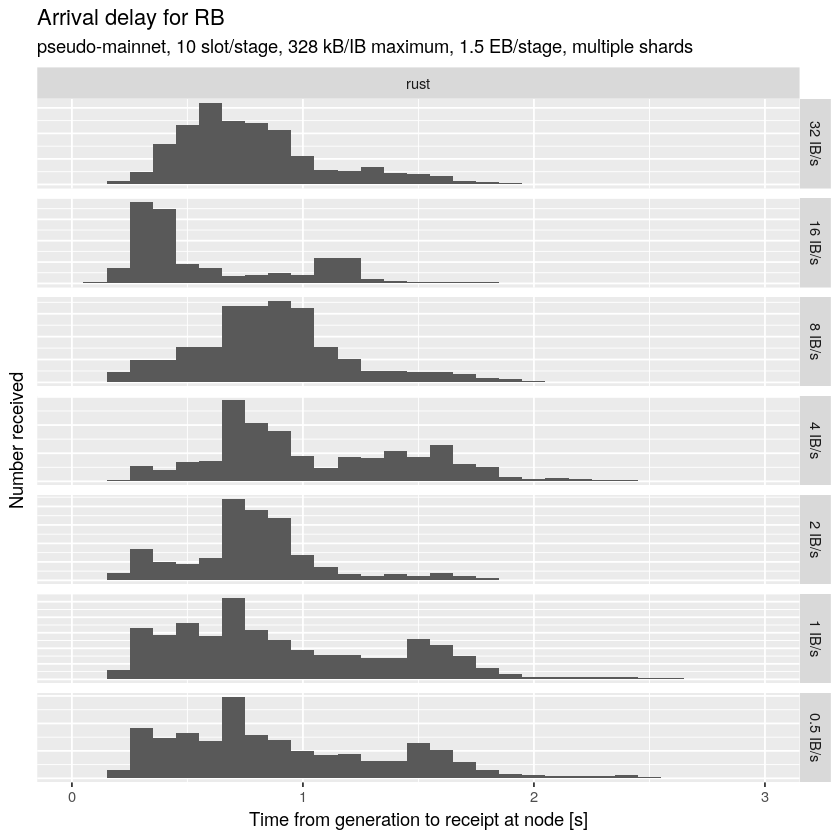

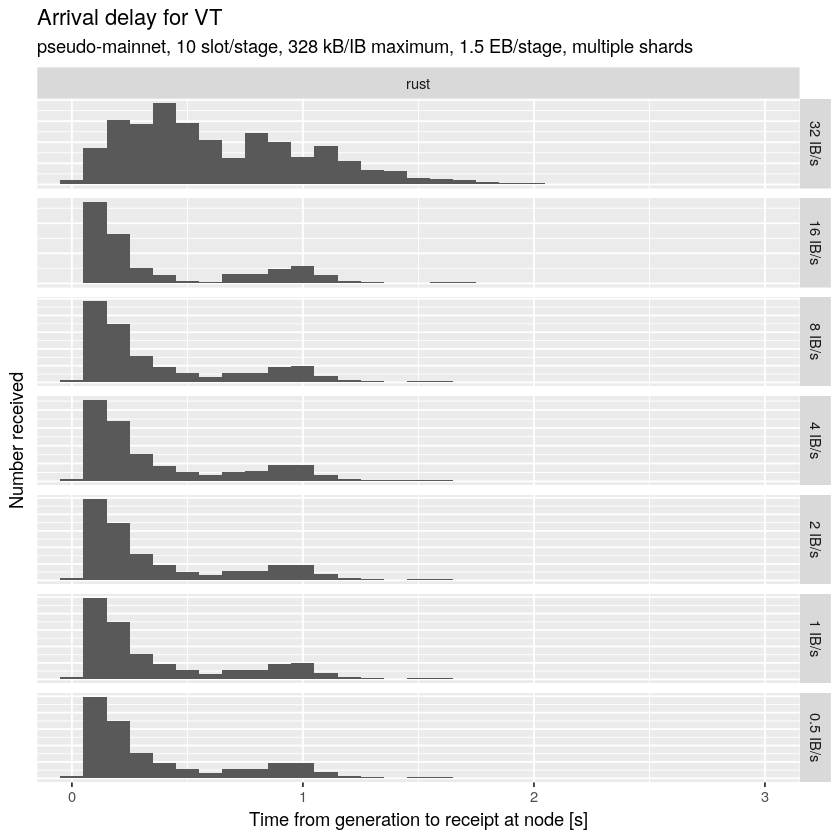

In [84]:
for (k in kinds)
    arrivalDelayHistogram(
        receipts[`Kind` == k],
        paste("Arrival delay for", k),
        scales="free_y",
        outfiles=paste0("plots/ibs/elapsed-", k, ".png")
    ) %>% print

#### Fraction of items arriving

In [85]:
arrivalFractionTimeseries <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(`Received`=as.numeric(.N)/sampling),
            by=.(`simulator`, `ibps`, `Generated [s]`, `Item`)
        ][,
            .(`Total`=as.numeric(.N), `Received`=sum(`Received`)),
            by=.(`simulator`, `ibps`, `Generated [s]`)
        ][,
            .(`Received`=sum(`Received`)/sum(`Total`)),
            by=.(`simulator`, `ibps`, `Generated [s]`)
        ][, .(
                `simulator`,
                `IB/s`=ibpsFactor(`ibps`),
                `Generated [s]`,
                `Received`
        )], 
        aes(x=`Generated [s]`, y=`Received`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`IB/s`  ~ `simulator`, scales=scales) +
        xlab("Time of generation [s]") +
        ylab("Number of nodes receiving") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

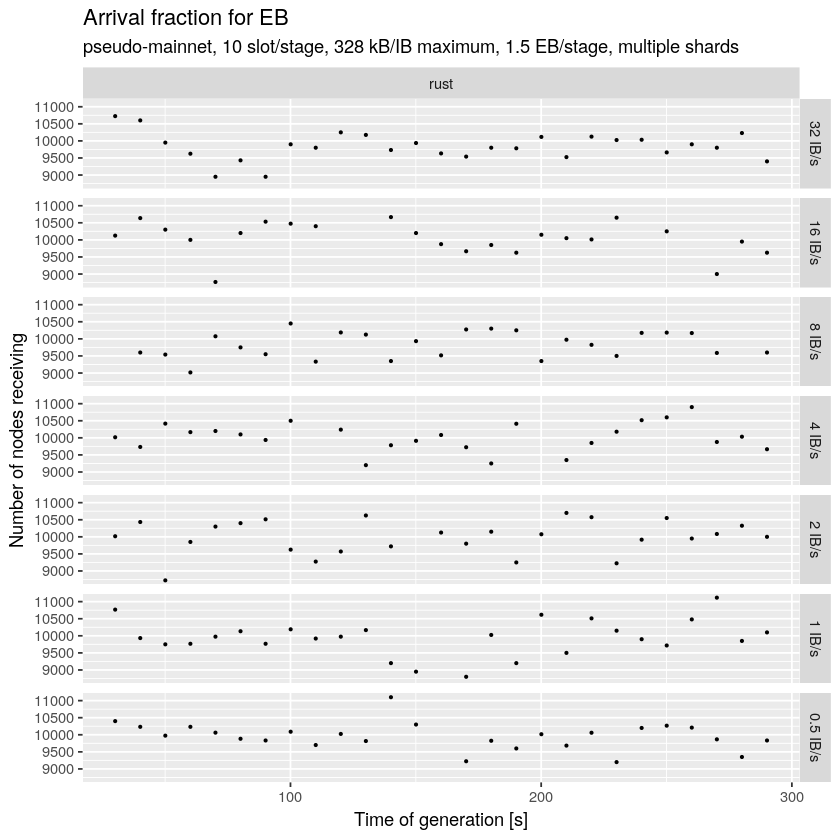

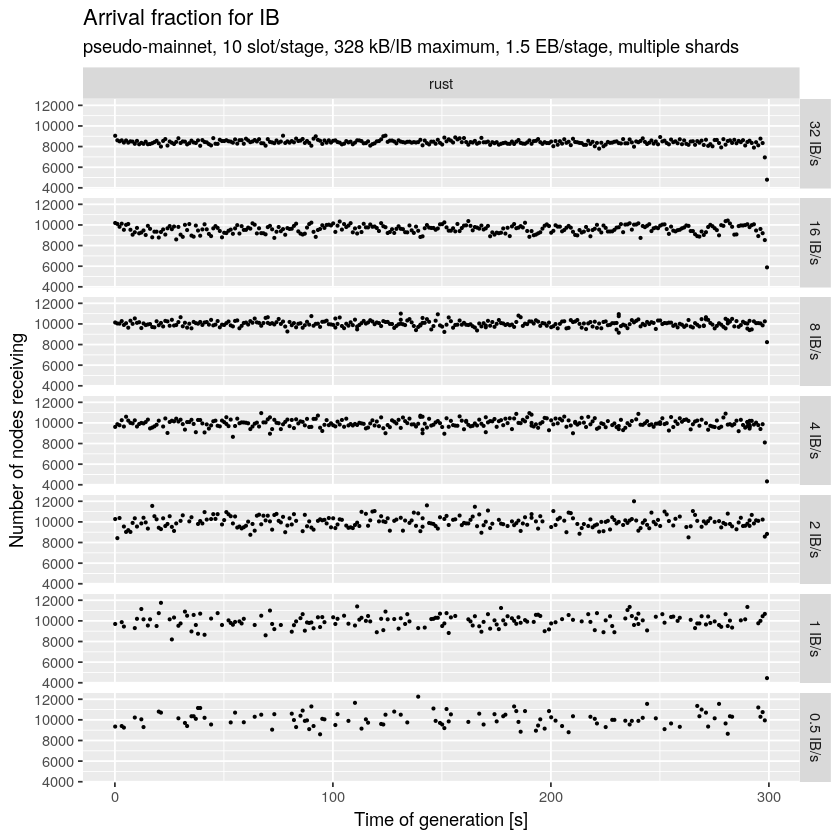

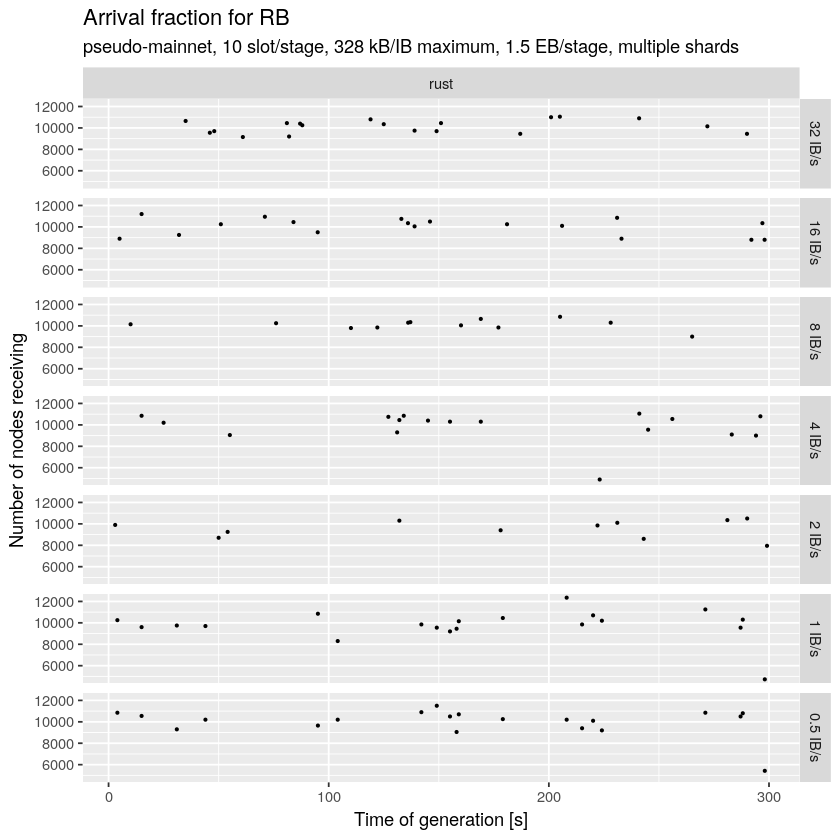

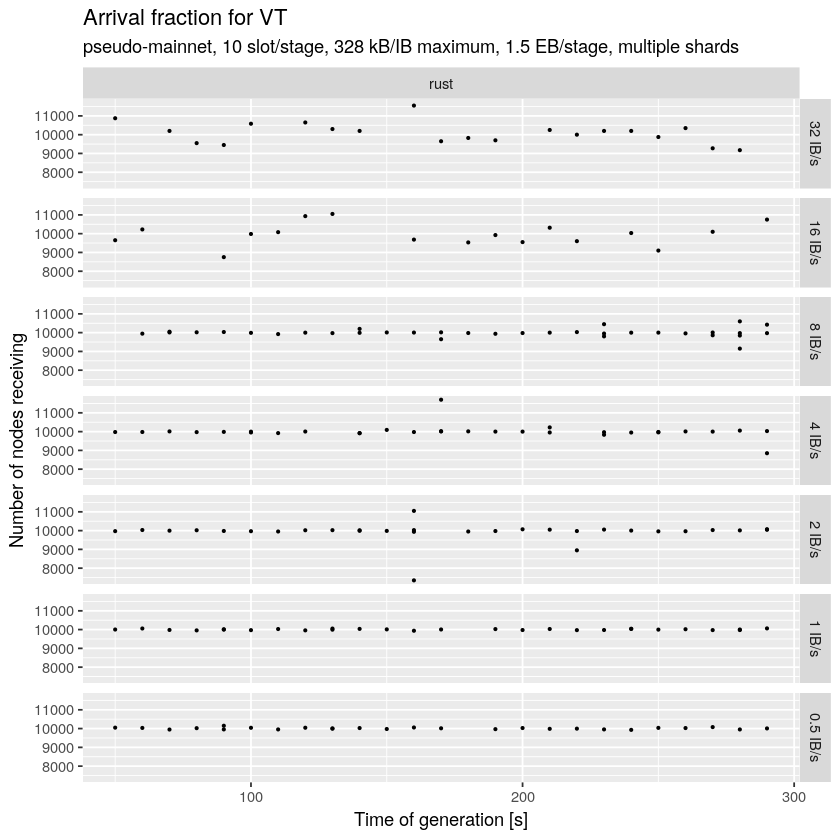

In [86]:
for (k in kinds)
    arrivalFractionTimeseries(
        receipts[`Kind` == k],
        paste("Arrival fraction for", k),
        outfiles=paste0("plots/ibs/arrival-", k, ".png")
    ) %>% print

#### Bandwidth usage

##### Total network bandwidth

In [ ]:
totalBandwidthPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `Size [GB]`=sum(`Size [B]`, rm.na=TRUE)/1000000000
            ),
            by=.(
                `Simulator`,
                `IB/s`=ibpsFactor(`IBPS`),
                `Slot`=floor(`Received [s]`),
                `Message`=`Kind`
            )
        ],
        aes(x=`Slot`, y=`Size [GB]`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`IB/s` ~ `Simulator`, scales=scales) +
        scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Total network ingress [GB/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

In [ ]:
totalBandwidthPlot(
    receipts,
    "Total bandwidth",
    outfiles=paste0("plots/ibs/ingress-total-area.png")
)

##### Bandwidth usage per node

In [ ]:
meanNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `Size [MB/node]`=sum(`Size [B]`)/1000000 / nodeCount
            ),
            by=.(
                `Simulator`,
                `IB/s`=ibpsFactor(`IBPS`),
                `Slot`=floor(`Received [s]`),
                `Message`=`Kind`
            )
        ],
        aes(x=`Slot`, y=`Size [MB/node]`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`IB/s` ~ `Simulator`, scales=scales) +
        scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Mean network ingress among nodes [MB/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

In [ ]:
meanNodalIngressPlot(
    receipts, 
    "Mean nodal ingress",
    outfiles=paste0("plots/ibs/ingress-average-area.png")
)

In [ ]:
peakNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `Size [MB]`=sum(`Size [B]`, rm.na=TRUE)/1000000
            ),
            by=.(
                `Simulator`,
                `IB/s`=ibpsFactor(`IBPS`),
                `Slot`=floor(`Received [s]`),
                `Message`=`Kind`,
                `Recipient`
            )
        ][,
            .(`Size [MB]`=max(`Size [MB]`)),
            by=.(`Simulator`, `IB/s`, `Slot`, `Message`)
        ],
        aes(x=`Slot`, y=`Size [MB]`, color=`Message`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`IB/s` ~ `Simulator`, scales=scales) +
        scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Maximum network ingress among nodes [MB/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

In [ ]:
peakNodalIngressPlot(
    receipts, 
    "Peak nodal ingress",
    outfiles=paste0("plots/ibs/ingress-peak-point.png")
)

#### Release memory

In [87]:
rm(receipts)

### CPU usage

#### Read results

In [88]:
cpus <- fread("results/ibs/cpus-2%sample.csv.gz", stringsAsFactors=TRUE)
cpus %>% summary

 simulator            ibps             Slot              Node         
 rust:30068771   Min.   : 0.500   Min.   :  0.0   node-9526:    3239  
                 1st Qu.: 1.000   1st Qu.:100.0   node-9892:    3238  
                 Median : 4.000   Median :160.0   node-5470:    3231  
                 Mean   : 7.514   Mean   :167.1   node-6175:    3231  
                 3rd Qu.: 8.000   3rd Qu.:240.0   node-601 :    3228  
                 Max.   :32.000   Max.   :300.0   node-4795:    3225  
                                                  (Other)  :30049379  
      Task           Duration [s]     
 ValVote:22663389   Min.   :0.000164  
 ValIH  : 3812874   1st Qu.:0.000816  
 ValIB  : 3465324   Median :0.000816  
 ValEB  :  100838   Mean   :0.017937  
 ValRB  :   23608   3rd Qu.:0.000816  
 GenVote:    2369   Max.   :0.181000  
 (Other):     369                     

In [89]:
cpusNode <-
cpus[
    ,
    .(
        `Duration [s]`=sum(`Duration [s]`)
    ),
    by=.(
        `simulator`,
        `IB/s`=ibpsFactor(`ibps`),
        `Node`,
        `Slot`
    )
]

#### Peak CPU usage

##### Histogram

In [90]:
peakCpuHistogram <- function(cs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(
                `Duration [%]`=100*max(`Duration [s]`)
            ),
            by=.(
                `simulator`,
                `IB/s`,
                `Slot`
            )
        ], 
        aes(x=`Duration [%]`)
    ) +
        geom_histogram(binwidth=10) +
        facet_grid(`IB/s` ~ `simulator`, scales=scales) +
      # coord_cartesian(xlim=c(0, 700)) +
        xlab("Peak CPU load [%]") +
        ylab("Number of slots") +
        ggtitle(title, subtitle="label")
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

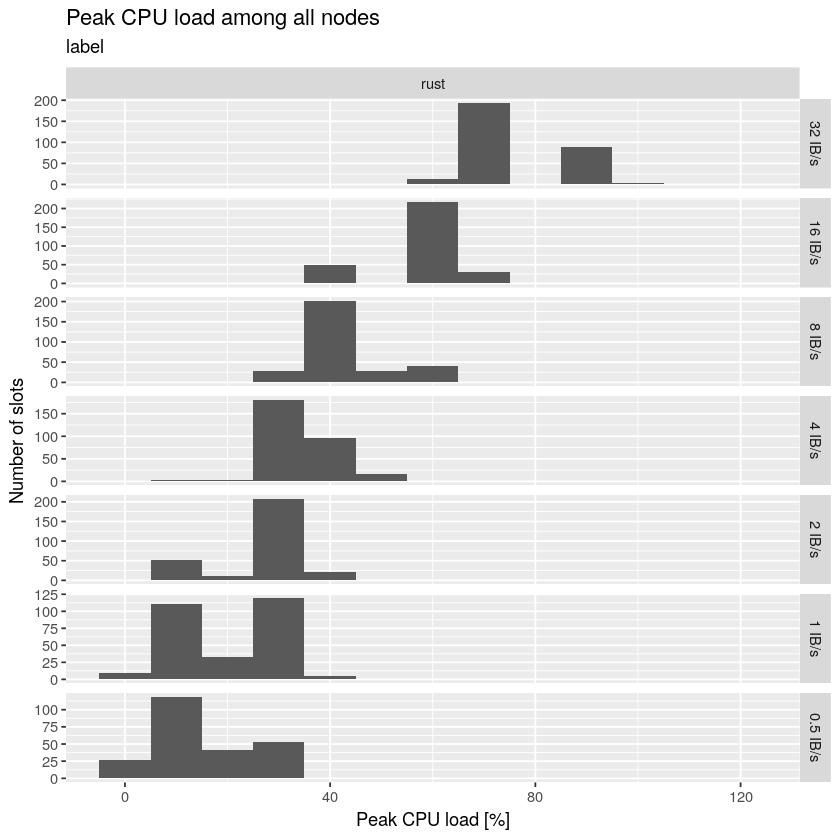

In [91]:
peakCpuHistogram(
    cpusNode, 
    "Peak CPU load among all nodes",
    scales="free_y",
    outfiles=paste0("plots/ibs/cpu-peak-histogram.png")
)

##### Time series

In [92]:
peakCpuTimeseries <- function(cs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(
                `Duration [%]`=100*mean(`Duration [s]`)
            ),
            by=.(
                `simulator`,
                `IB/s`,
                `Slot`
            )
        ], 
        aes(x=`Slot`, y=`Duration [%]`)) +
        geom_line() +
        facet_grid(`IB/s` ~ `simulator`, scale=scales) +
        scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

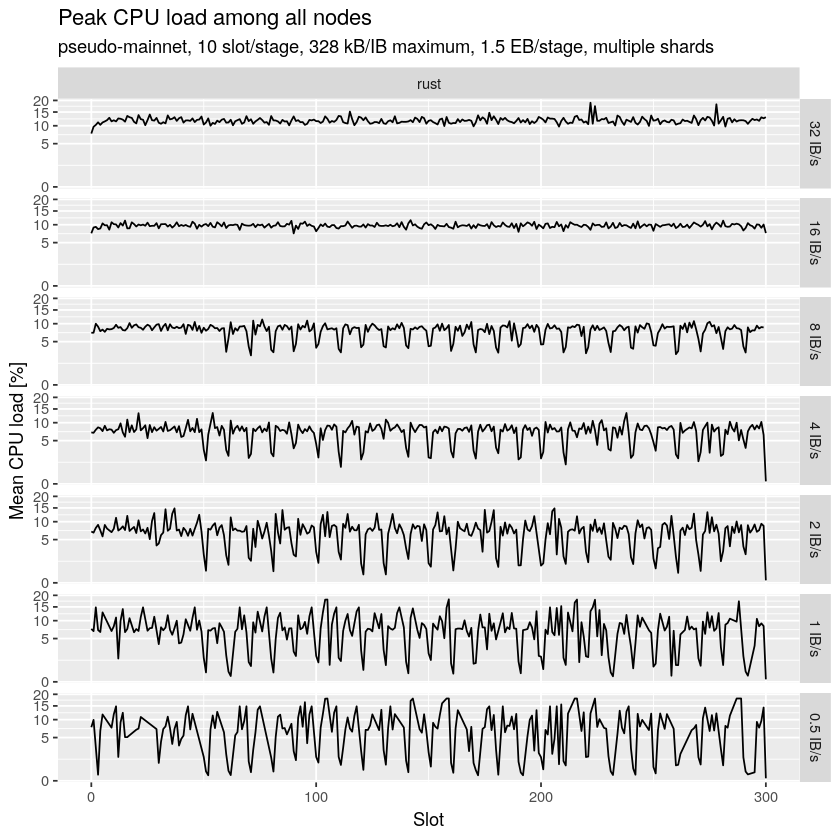

In [93]:
peakCpuTimeseries(
    cpusNode,
    "Peak CPU load among all nodes",
    outfiles=paste0("plots/ibs/cpu-peak-timeseries.png")
)

#### Mean CPU usage

##### Histogram

In [94]:
meanCpuHistogram <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(
                `Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds/sampling
            ),
            by=.(
                `simulator`,
                `IB/s`=ibpsFactor(`ibps`),
                `Task`
            )
        ], 
        aes(x="", fill=`Task`, y=`Duration [%]`)) +
        geom_bar(stat = "identity") +
        facet_grid(`IB/s` ~ `simulator`, scales=scales) +
        xlab("") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

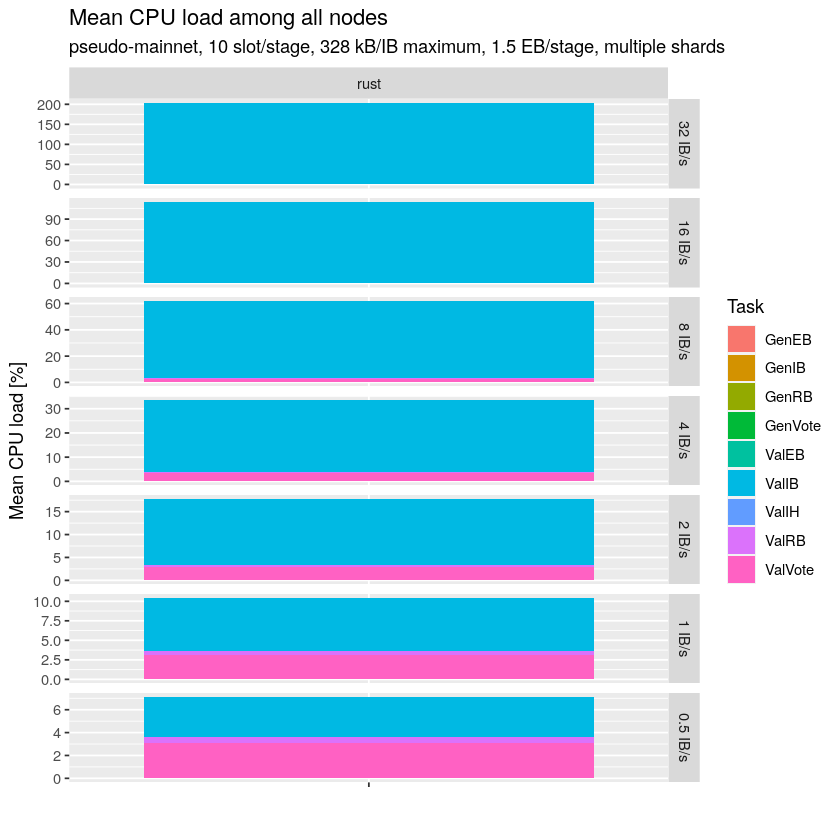

In [95]:
meanCpuHistogram(
    cpus,
    nodeCount * txWindow, 
    "Mean CPU load among all nodes", 
    scales="free_y",
    outfiles=paste0("plots/ibs/cpu-mean-histogram.png")
)

##### Time series

In [96]:
meanCpuTimeseries <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(
                `Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds/sampling
            ),
            by=.(
                `simulator`,
                `IB/s`=ibpsFactor(`ibps`),
                `Slot`,
                `Task`
            )
        ], 
        aes(x=`Slot`, y=`Duration [%]`, color=`Task`)
    ) +
        geom_point(size=0.25, alpha=0.75) +
        facet_grid(`IB/s` ~ `simulator`, scales=scales) +
        scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

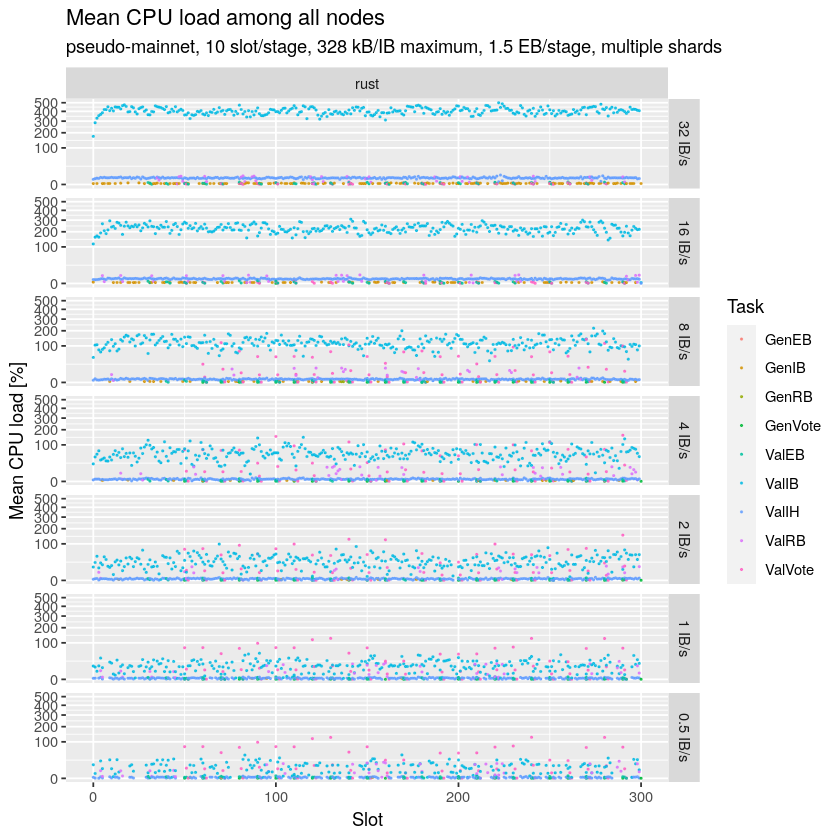

In [97]:
meanCpuTimeseries(
    cpus, 
    nodeCount, 
    "Mean CPU load among all nodes",
    outfiles=paste0("plots/ibs/cpu-mean-timeseries.png")
)

#### Release memory

In [98]:
rm(cpus, cpusNode)